https://www.kaggle.com/therealcyberlord/coronavirus-covid-19-visualization-prediction

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/07-27-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/07-27-2020.csv')

In [4]:
latest_data.head()

FIPS     Admin2  Province_State Country_Region          Last_Update  \
0  45001.0  Abbeville  South Carolina             US  2020-07-28 04:58:43   
1  22001.0     Acadia       Louisiana             US  2020-07-28 04:58:43   
2  51001.0   Accomack        Virginia             US  2020-07-28 04:58:43   
3  16001.0        Ada           Idaho             US  2020-07-28 04:58:43   
4  19001.0      Adair            Iowa             US  2020-07-28 04:58:43   

         Lat       Long_  Confirmed  Deaths  Recovered  Active  \
0  34.223334  -82.461707        272       4          0   268.0   
1  30.295065  -92.414197       2215      63          0  2152.0   
2  37.767072  -75.632346       1065      15          0  1050.0   
3  43.452658 -116.241552       7203      47          0  7156.0   
4  41.330756  -94.471059         20       0          0    20.0   

                    Combined_Key  Incidence_Rate  Case-Fatality_Ratio  
0  Abbeville, South Carolina, US     1108.981938             1.470588  
1          Acadia, Louisiana, US     3569.989524             2.844244  
2         Accomack, Virginia, US     3295.581136             1.408451  
3                 Ada, Idaho, US     1495.679908             0.652506  
4                Adair, Iowa, US      279.642058             0.000000

In [5]:
confirmed_df.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  7/18/20  7/19/20  7/20/20  \
0        0        0        0        0  ...    35301    35475    35526   
1        0        0        0        0  ...     4008     4090     4171   
2        0        0        0        0  ...    22549    23084    23691   
3        0        0        0        0  ...      880      880      884   
4        0        0        0        0  ...      687      705      749   

   7/21/20  7/22/20  7/23/20  7/24/20  7/25/20  7/26/20  7/27/20  
0    35615    35727    35928    35981    36036    36157    36263  
1     4290     4358     4466     4570     4637     4763     4880  
2    24278    24872    25484    26159    26764    27357    27973  
3      884      889      889      897      897      897      907  
4      779      812      851      880      916      932      950  

[5 rows x 192 columns]

In [6]:
us_medical_data.head()

Province_State Country_Region          Last_Update      Lat     Long_  \
0         Alabama             US  2020-07-28 04:59:02  32.3182  -86.9023   
1          Alaska             US  2020-07-28 04:59:02  61.3707 -152.4044   
2  American Samoa             US  2020-07-28 04:59:02 -14.2710 -170.1320   
3         Arizona             US  2020-07-28 04:59:02  33.7298 -111.4312   
4        Arkansas             US  2020-07-28 04:59:02  34.9697  -92.3731   

   Confirmed  Deaths  Recovered    Active  FIPS  Incident_Rate  People_Tested  \
0      81115    1491    32510.0   47114.0     1    1654.332847       657959.0   
1       2623      21      817.0    1785.0     2     358.556206       207368.0   
2          0       0        NaN       0.0    60       0.000000         1037.0   
3     163827    3304    21321.0  139202.0     4    2250.767546       878333.0   
4      39447     408    32365.0    6674.0     5    1307.142545       484891.0   

   People_Hospitalized  Mortality_Rate       UID ISO3  Testing_Rate  \
0               9694.0        1.838131  84000001  USA  13419.012336   
1                  NaN        0.800610  84000002  USA  28346.581550   
2                  NaN             NaN        16  ASM   1863.733578   
3               7751.0        2.016762  84000004  USA  12067.140404   
4               2624.0        1.034299  84000005  USA  16067.677026   

   Hospitalization_Rate  
0             11.950934  
1                   NaN  
2                   NaN  
3              4.731210  
4              6.651963

In [8]:
cols = confirmed_df.keys()

Get all the dates for the outbreak

In [9]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [10]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
france_cases = [] 
germany_cases = [] 
uk_cases = [] 
russia_cases = [] 
brazil_cases = []
india_cases = []
peru_cases = [] 

china_deaths = [] 
italy_deaths = []
us_deaths = [] 
spain_deaths = [] 
france_deaths = [] 
germany_deaths = [] 
uk_deaths = [] 
russia_deaths = []
brazil_deaths = [] 
india_deaths = []
peru_deaths = []

china_recoveries = [] 
italy_recoveries = []
us_recoveries = [] 
spain_recoveries = [] 
france_recoveries = [] 
germany_recoveries = [] 
uk_recoveries = [] 
russia_recoveries = [] 
brazil_recoveries = [] 
india_recoveries = [] 
peru_recoveries = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())
    france_cases.append(confirmed_df[confirmed_df['Country/Region']=='France'][i].sum())
    germany_cases.append(confirmed_df[confirmed_df['Country/Region']=='Germany'][i].sum())
    uk_cases.append(confirmed_df[confirmed_df['Country/Region']=='United Kingdom'][i].sum())
    russia_cases.append(confirmed_df[confirmed_df['Country/Region']=='Russia'][i].sum())
    brazil_cases.append(confirmed_df[confirmed_df['Country/Region']=='Brazil'][i].sum())
    india_cases.append(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())
    peru_cases.append(confirmed_df[confirmed_df['Country/Region']=='Peru'][i].sum())
    
    # moving average for case studies 
    china_deaths.append(deaths_df[deaths_df['Country/Region']=='China'][i].sum())
    italy_deaths.append(deaths_df[deaths_df['Country/Region']=='Italy'][i].sum())
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    spain_deaths.append(deaths_df[deaths_df['Country/Region']=='Spain'][i].sum())
    france_deaths.append(deaths_df[deaths_df['Country/Region']=='France'][i].sum())
    germany_deaths.append(deaths_df[deaths_df['Country/Region']=='Germany'][i].sum())
    uk_deaths.append(deaths_df[deaths_df['Country/Region']=='United Kingdom'][i].sum())
    russia_deaths.append(deaths_df[deaths_df['Country/Region']=='Russia'][i].sum())
    brazil_deaths.append(deaths_df[deaths_df['Country/Region']=='Brazil'][i].sum())
    india_deaths.append(deaths_df[deaths_df['Country/Region']=='India'][i].sum())
    peru_deaths.append(deaths_df[deaths_df['Country/Region']=='Peru'][i].sum())
    
    china_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='China'][i].sum())
    italy_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Italy'][i].sum())
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
    spain_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Spain'][i].sum())
    france_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='France'][i].sum())
    germany_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Germany'][i].sum())
    uk_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='United Kingdom'][i].sum())
    russia_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Russia'][i].sum())
    brazil_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Brazil'][i].sum())
    india_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='India'][i].sum())
    peru_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Peru'][i].sum())

Getting daily increases and moving averages

In [11]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 14

# confirmed cases
world_daily_increase = daily_increase(world_cases)
world_confirmed_avg= moving_average(world_cases, window)
world_daily_increase_avg = moving_average(world_daily_increase, window)

china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
france_daily_increase = daily_increase(france_cases)
germany_daily_increase = daily_increase(germany_cases)
uk_daily_increase = daily_increase(uk_cases)
russia_daily_increase = daily_increase(russia_cases)
brazil_daily_increase = daily_increase(brazil_cases)
india_daily_increase = daily_increase(india_cases)
peru_daily_increase = daily_increase(peru_cases)

# deaths
world_daily_death = daily_increase(total_deaths)
world_death_avg = moving_average(total_deaths, window)
world_daily_death_avg = moving_average(world_daily_death, window)

china_daily_death = daily_increase(china_deaths)
italy_daily_death = daily_increase(italy_deaths)
us_daily_death = daily_increase(us_deaths)
spain_daily_death = daily_increase(spain_deaths)
france_daily_death = daily_increase(france_deaths)
germany_daily_death = daily_increase(germany_deaths)
uk_daily_death = daily_increase(uk_deaths)
russia_daily_death = daily_increase(russia_deaths)
brazil_daily_death = daily_increase(brazil_deaths)
india_daily_death = daily_increase(india_deaths)
peru_daily_death = daily_increase(peru_deaths)


# recoveries
world_daily_recovery = daily_increase(total_recovered)
world_recovery_avg = moving_average(total_recovered, window)
world_daily_recovery_avg = moving_average(world_daily_recovery, window)

china_daily_recovery = daily_increase(china_recoveries)
italy_daily_recovery = daily_increase(italy_recoveries)
us_daily_recovery = daily_increase(us_recoveries)
spain_daily_recovery = daily_increase(spain_recoveries)
france_daily_recovery = daily_increase(france_recoveries)
germany_daily_recovery = daily_increase(germany_recoveries)
uk_daily_recovery = daily_increase(uk_recoveries)
russia_daily_recovery = daily_increase(russia_recoveries)
brazil_daily_recovery = daily_increase(brazil_recoveries)
india_daily_recovery = daily_increase(india_recoveries)
peru_daily_recovery = daily_increase(peru_recoveries)

# active 
world_active_avg = moving_average(total_active, window)

In [12]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Future forcasting

In [13]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [14]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [15]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], world_cases[50:], test_size=0.12, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example.

In [17]:
# # use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [19]:
# svm_search.best_params_

In [20]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

C:\Anaconda3_64\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 114776.89179562262
MSE: 17221496118.256657


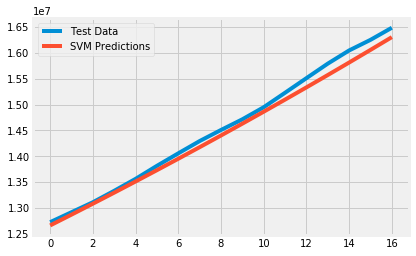

In [21]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [22]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [23]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 184672.9217689949
MSE: 49661336172.04864


In [24]:
print(linear_model.coef_)

[[ 1.80231382e+07 -9.88818305e+05  1.96961240e+04 -1.76700083e+02
   7.64163707e-01 -1.24521665e-03]]


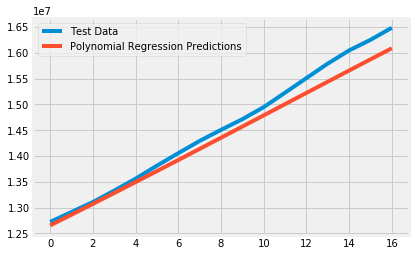

In [25]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [27]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 105 out of 120 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
C:\Anaconda3_64\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [28]:
bayesian_search.best_params_

{'tol': 0.01,
 'normalize': False,
 'lambda_2': 1e-07,
 'lambda_1': 0.001,
 'alpha_2': 1e-06,
 'alpha_1': 0.0001}

In [29]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 612191.1272290298
MSE: 424857116034.4079


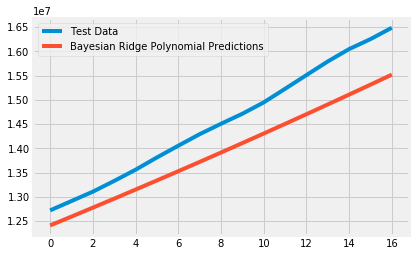

In [30]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

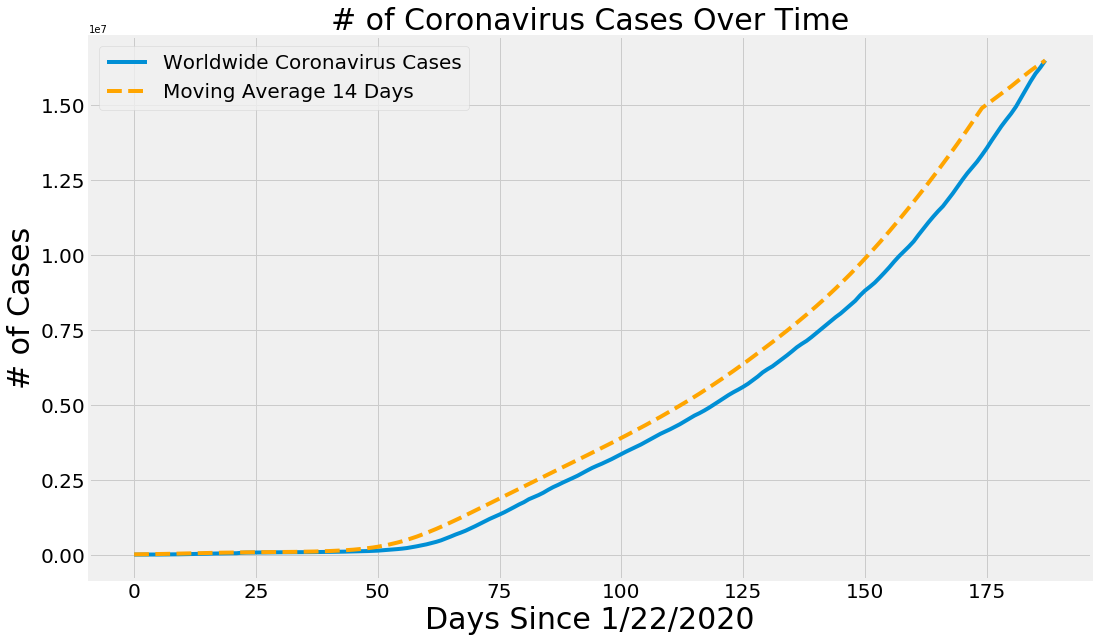

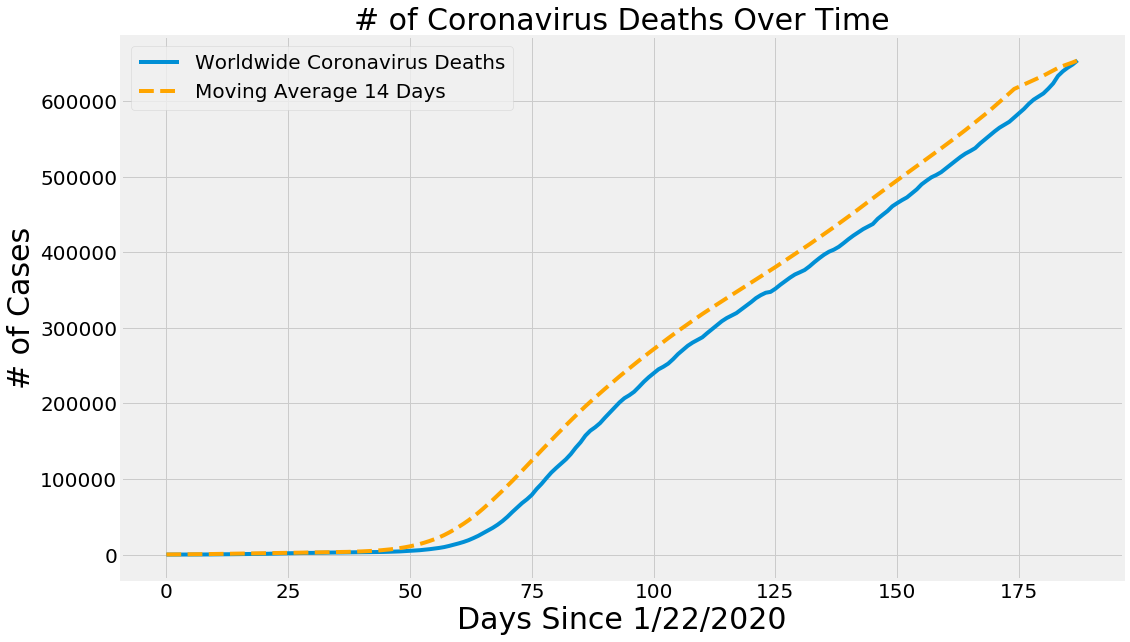

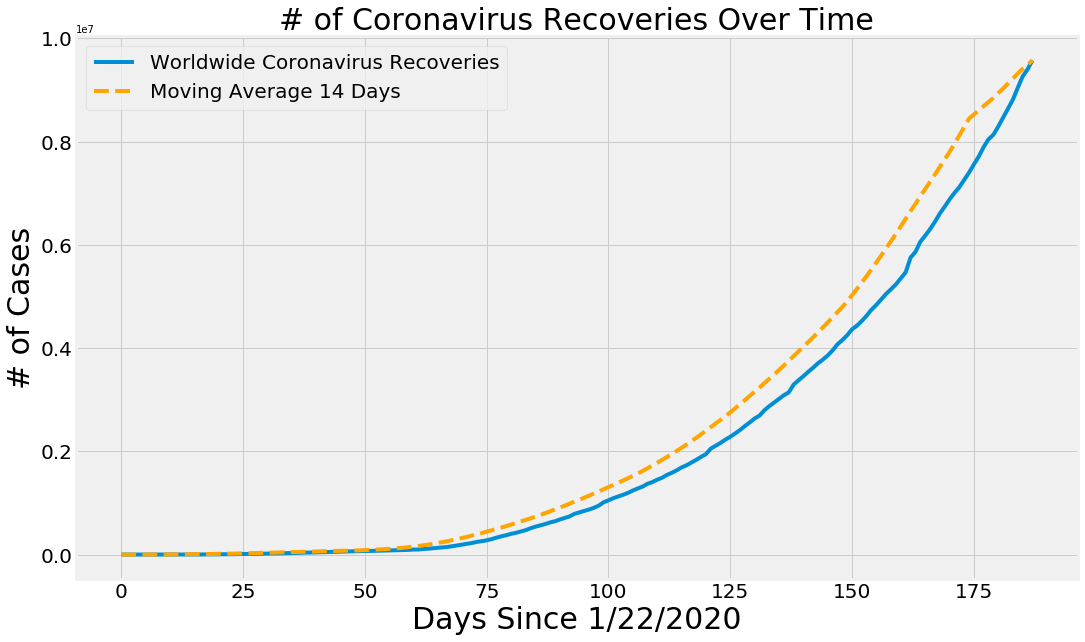

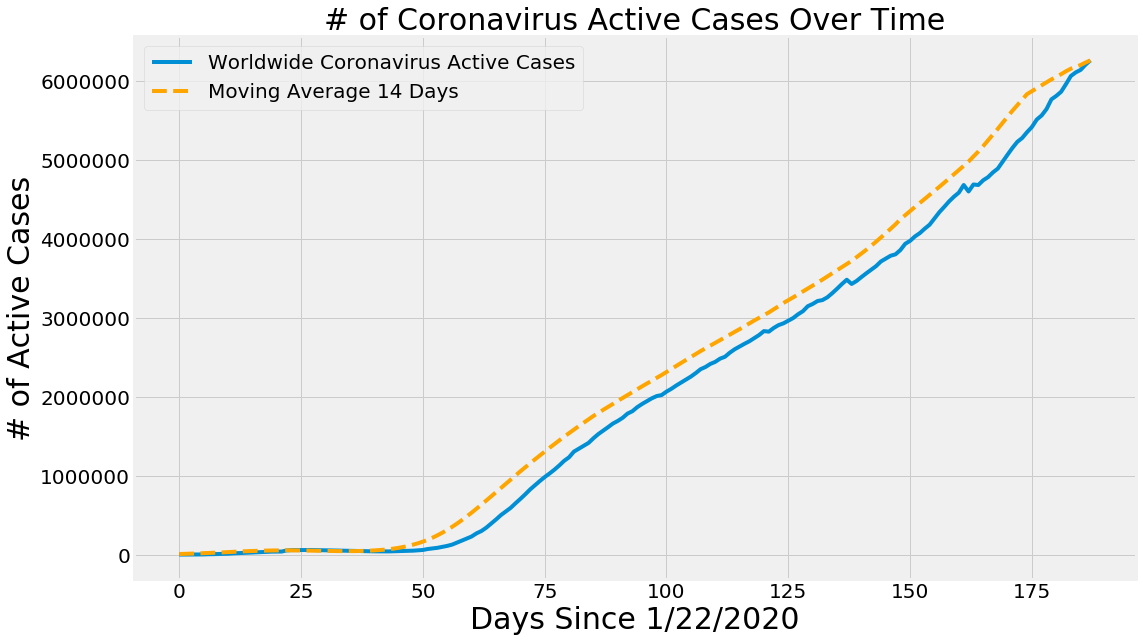

In [31]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, world_cases)
plt.plot(adjusted_dates, world_confirmed_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Cases', 'Moving Average 14 Days'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_deaths)
plt.plot(adjusted_dates, world_death_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Deaths', 'Moving Average 14 Days'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_recovered)
plt.plot(adjusted_dates, world_recovery_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Worldwide Coronavirus Recoveries', 'Moving Average 14 Days'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_active)
plt.plot(adjusted_dates, world_active_avg, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.legend(['Worldwide Coronavirus Active Cases', 'Moving Average 14 Days'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

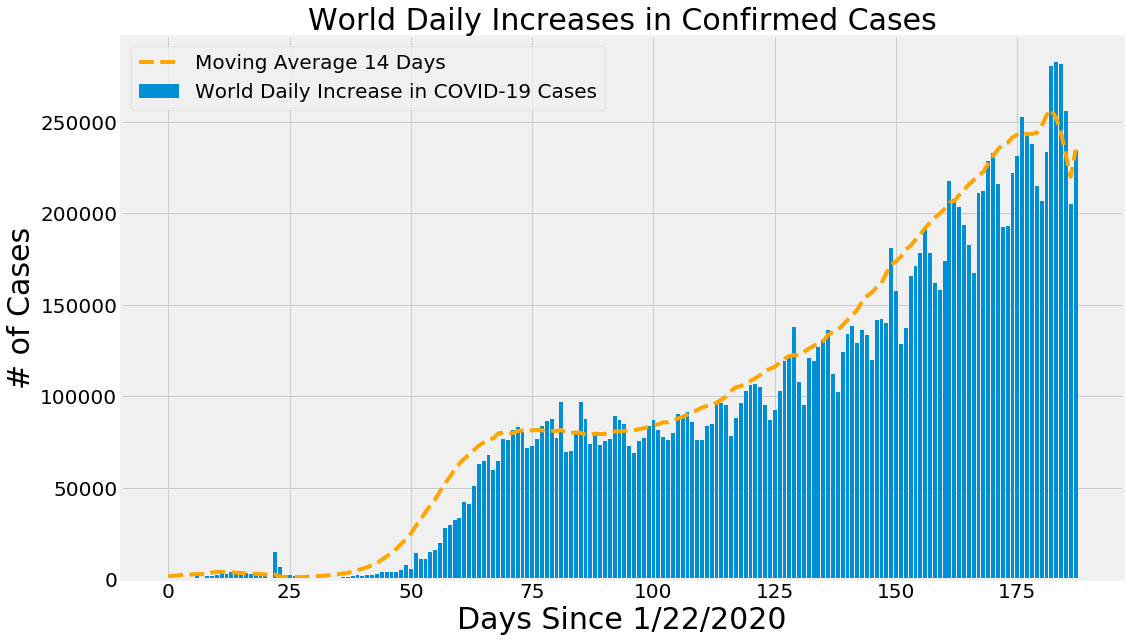

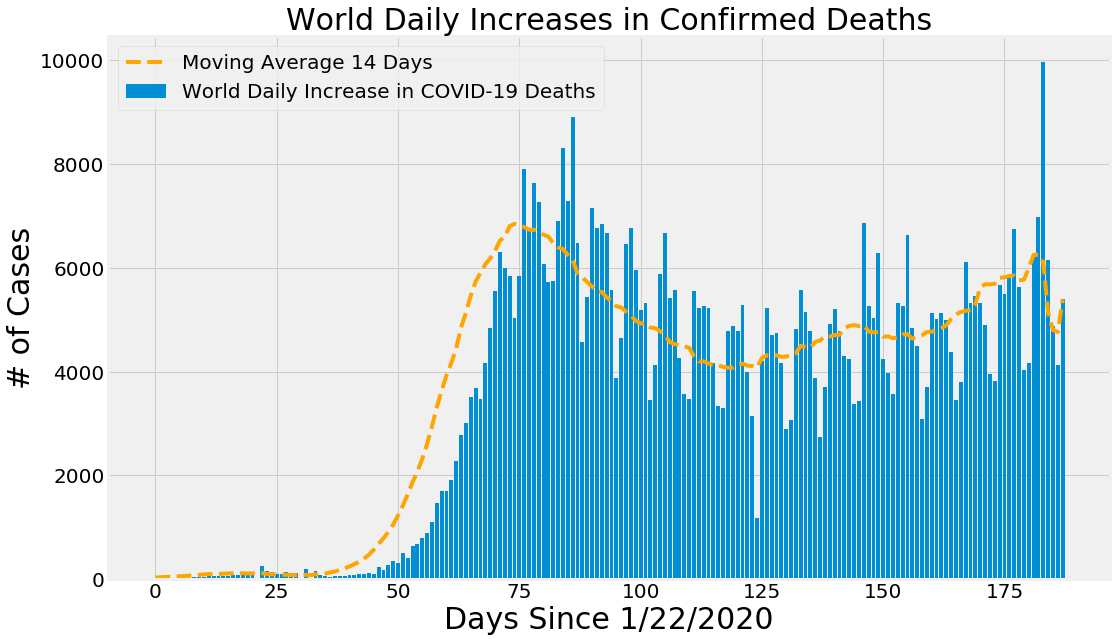

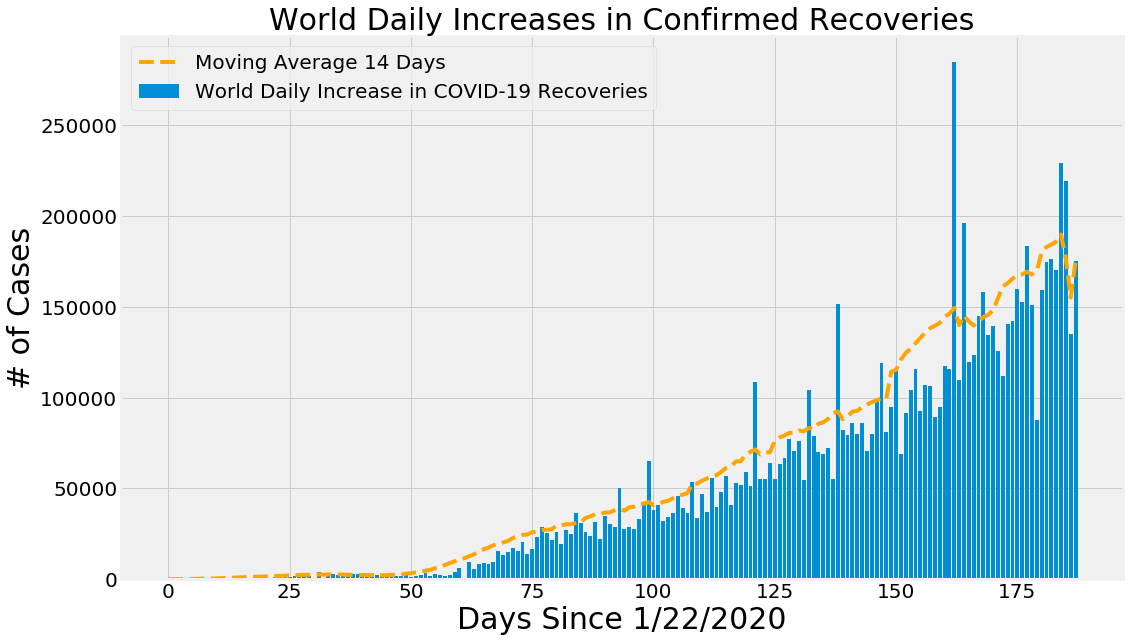

In [32]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(adjusted_dates, world_daily_increase_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average 14 Days', 'World Daily Increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_death)
plt.plot(adjusted_dates, world_daily_death_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average 14 Days', 'World Daily Increase in COVID-19 Deaths'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_recovery)
plt.plot(adjusted_dates, world_daily_recovery_avg, color='orange', linestyle='dashed')
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Moving Average 14 Days', 'World Daily Increase in COVID-19 Recoveries'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

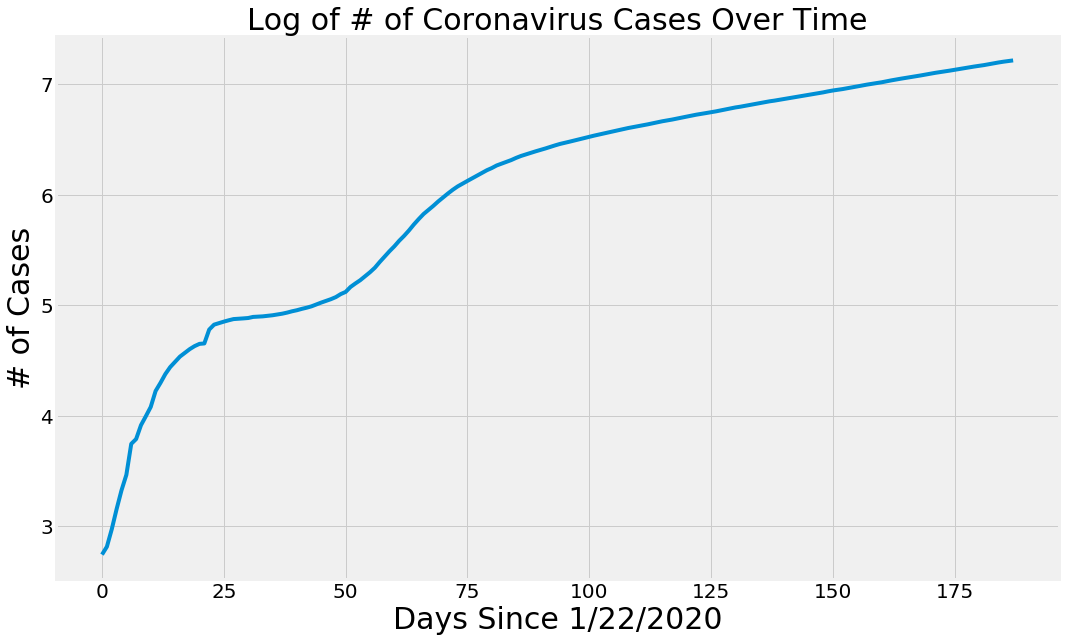

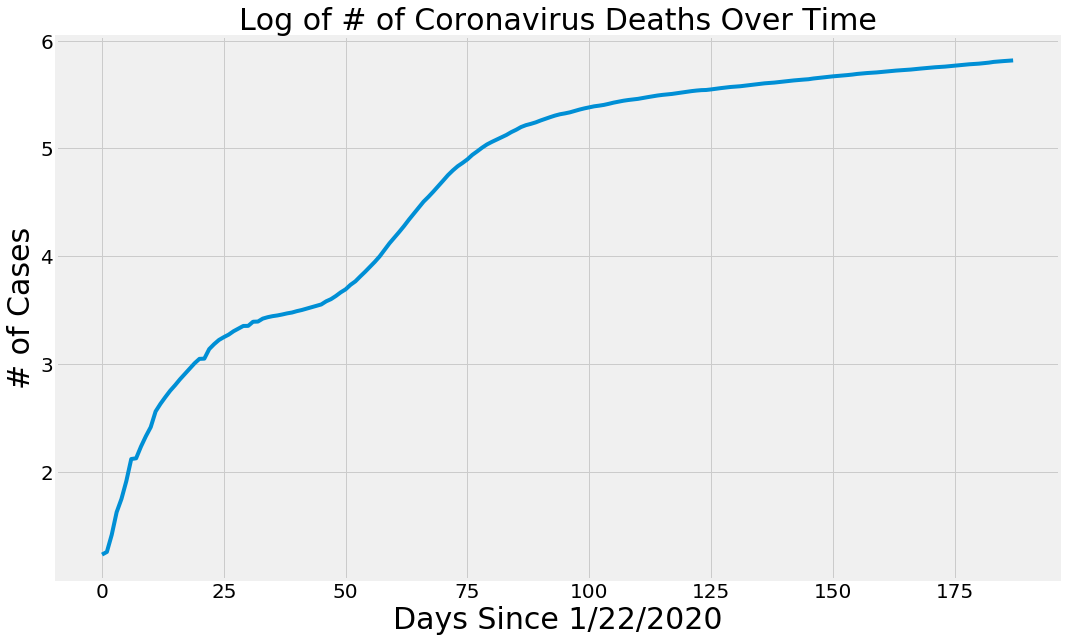

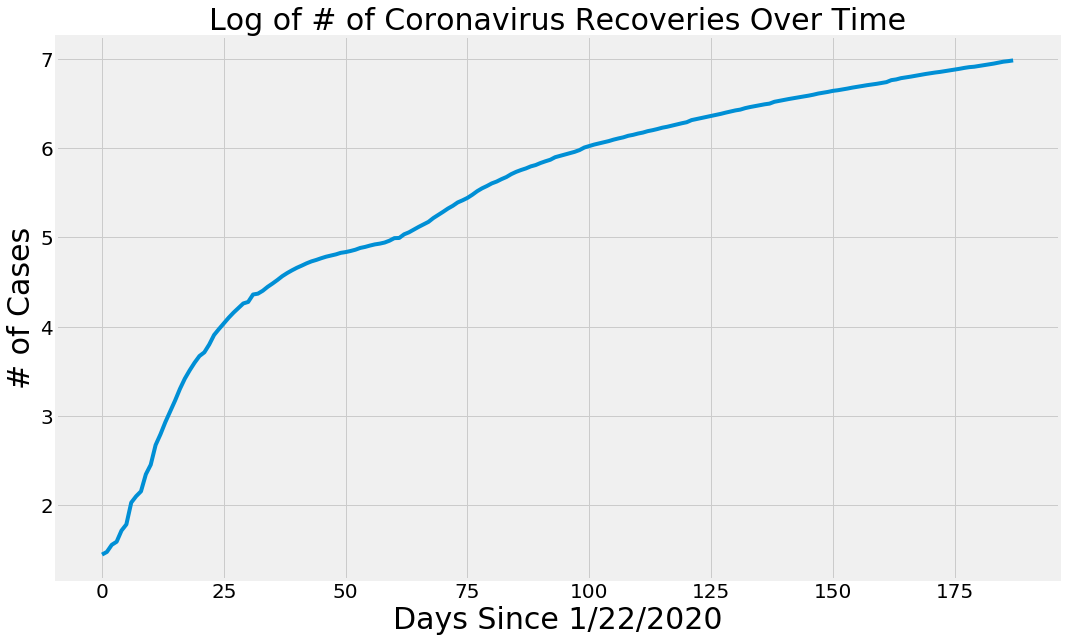

In [33]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(total_deaths))
plt.title('Log of # of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, np.log10(total_recovered))
plt.title('Log of # of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [35]:
def country_plot(x, y1, y2, y3, y4, country):
    # window is set as 14 in in the beginning of the notebook 
    confirmed_avg = moving_average(y1, window)
    confirmed_increase_avg = moving_average(y2, window)
    death_increase_avg = moving_average(y3, window)
    recovery_increase_avg = moving_average(y4, window)
    
    plt.figure(figsize=(16, 10))
    plt.plot(x, y1)
    plt.plot(x, confirmed_avg, color='red', linestyle='dashed')
    plt.legend(['{} Confirmed Cases'.format(country), 'Moving Average 14 Days'], prop={'size': 20})
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y2)
    plt.plot(x, confirmed_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average 14 Days', '{} Daily Increase in Confirmed Cases'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y3)
    plt.plot(x, death_increase_avg, color='red', linestyle='dashed')
    plt.legend(['Moving Average 14 Days', '{} Daily Increase in Confirmed Deaths'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 10))
    plt.bar(x, y4)
    plt.plot(x, recovery_increase_avg, color='red', linestyle='dashed')
    plt.legend([ 'Moving Average 14 Days', '{} Daily Increase in Confirmed Recoveries'.format(country)], prop={'size': 20})
    plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()


## Country Specific Graphs

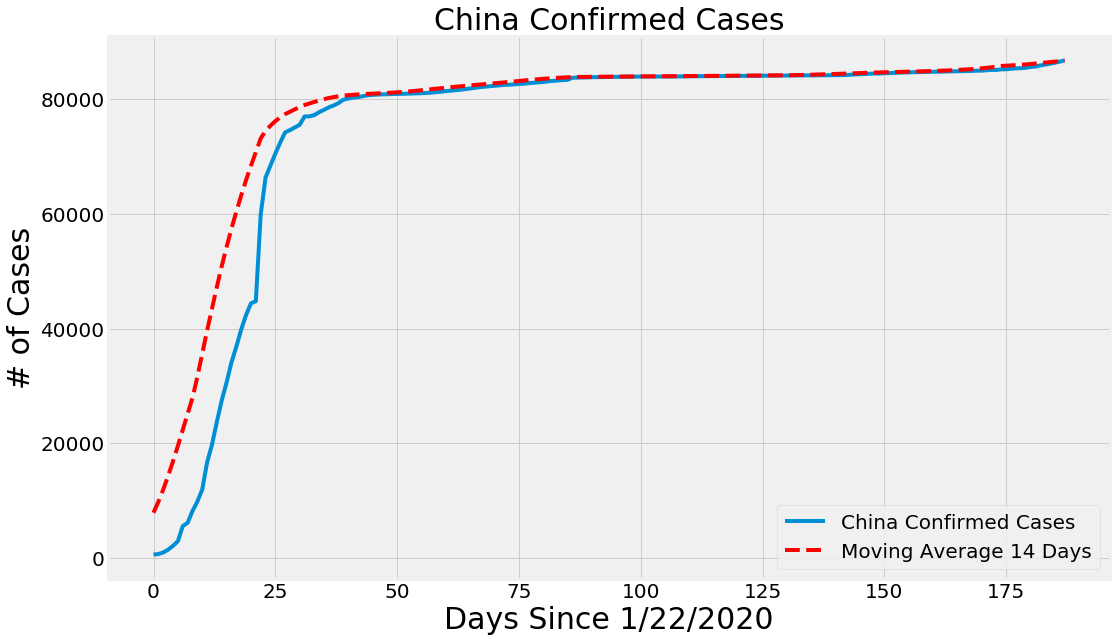

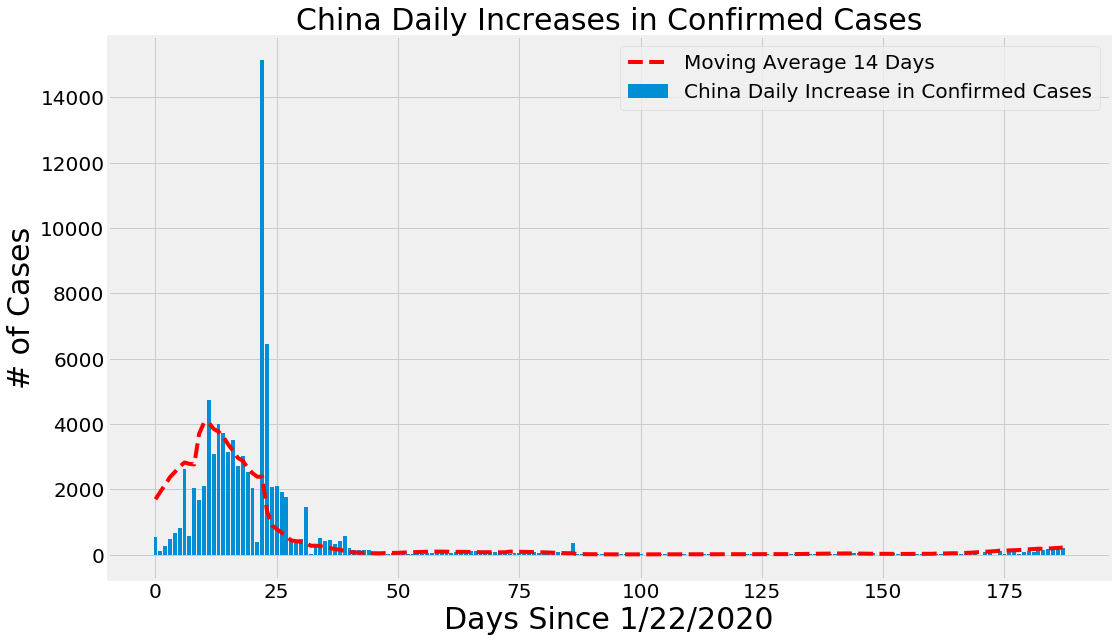

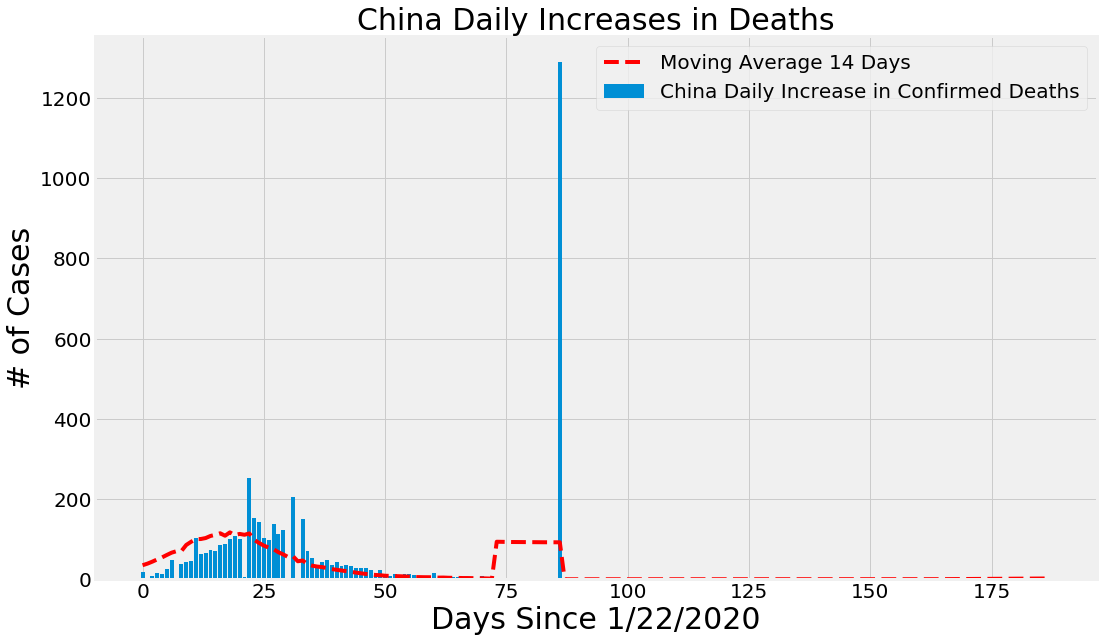

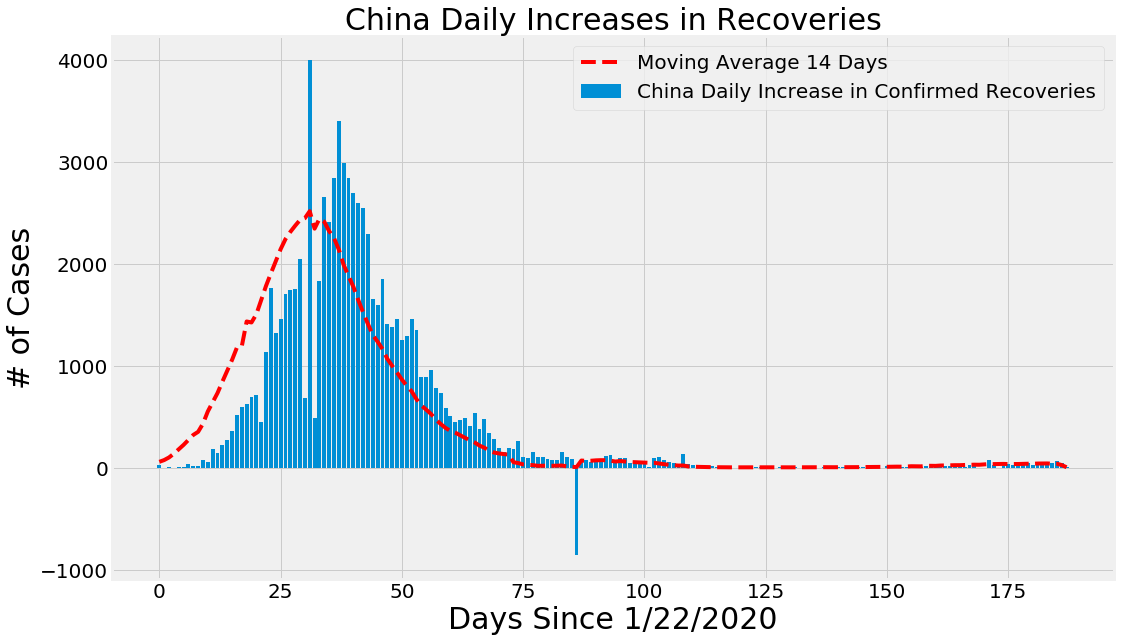

In [36]:
country_plot(adjusted_dates, china_cases, china_daily_increase, china_daily_death, china_daily_recovery, 'China')

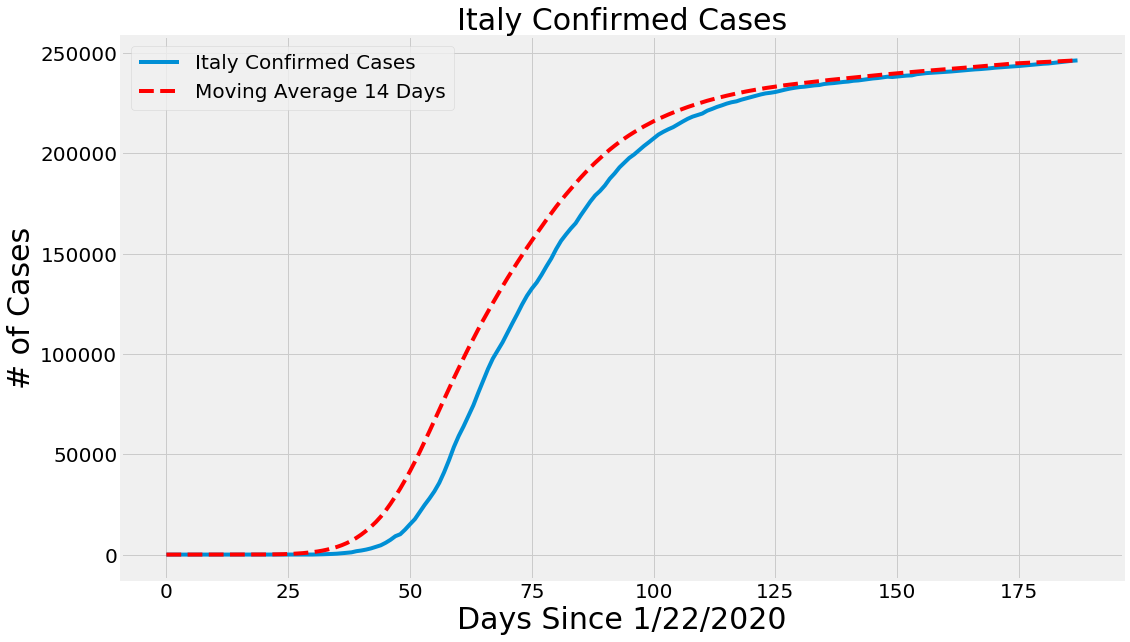

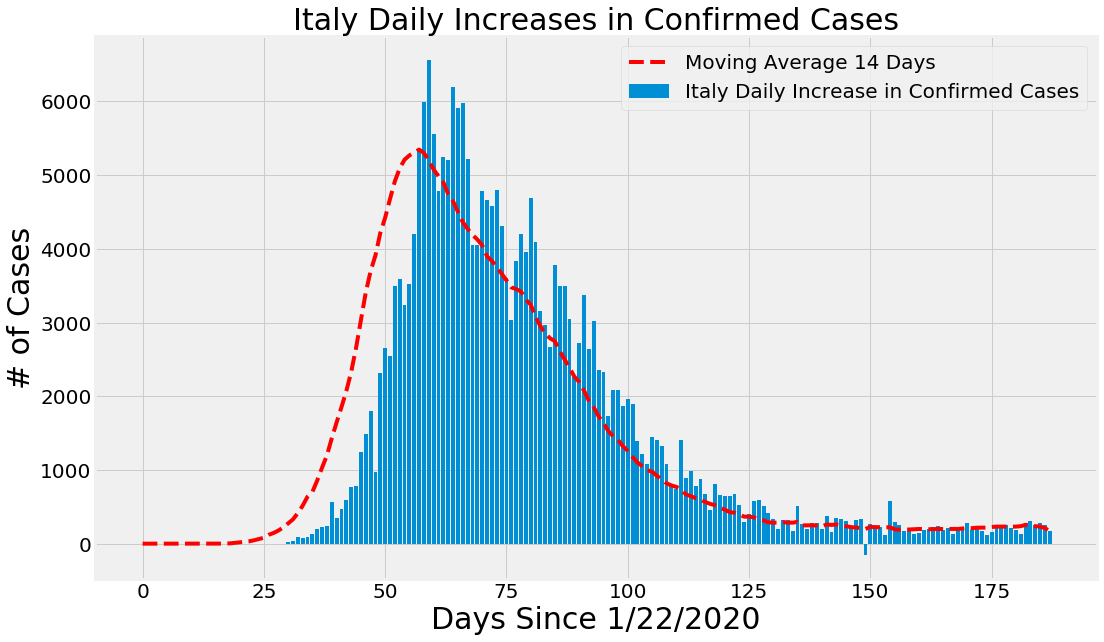

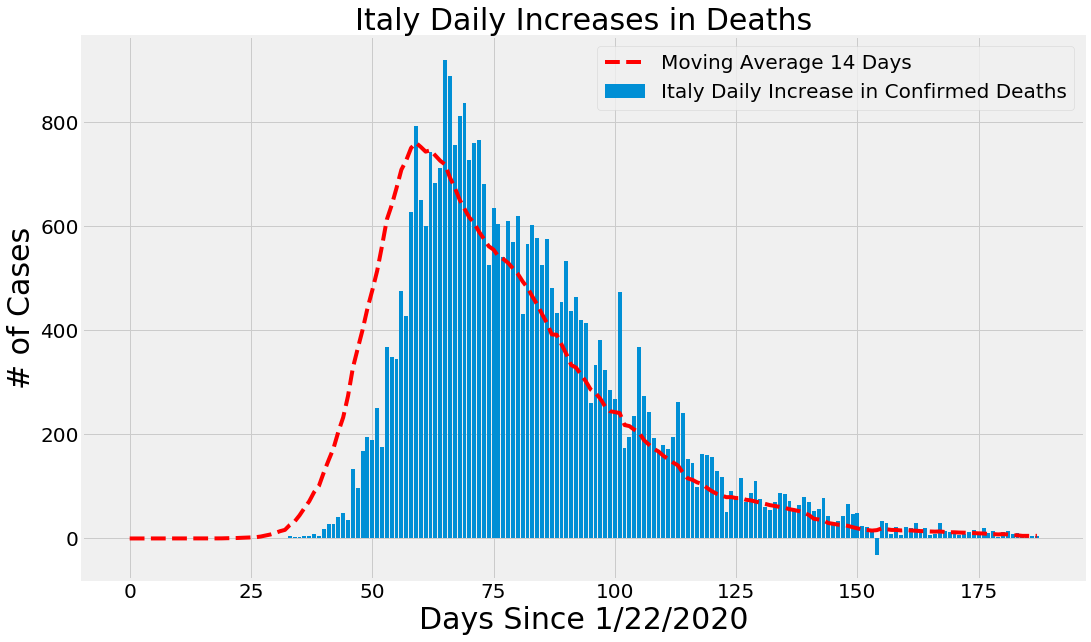

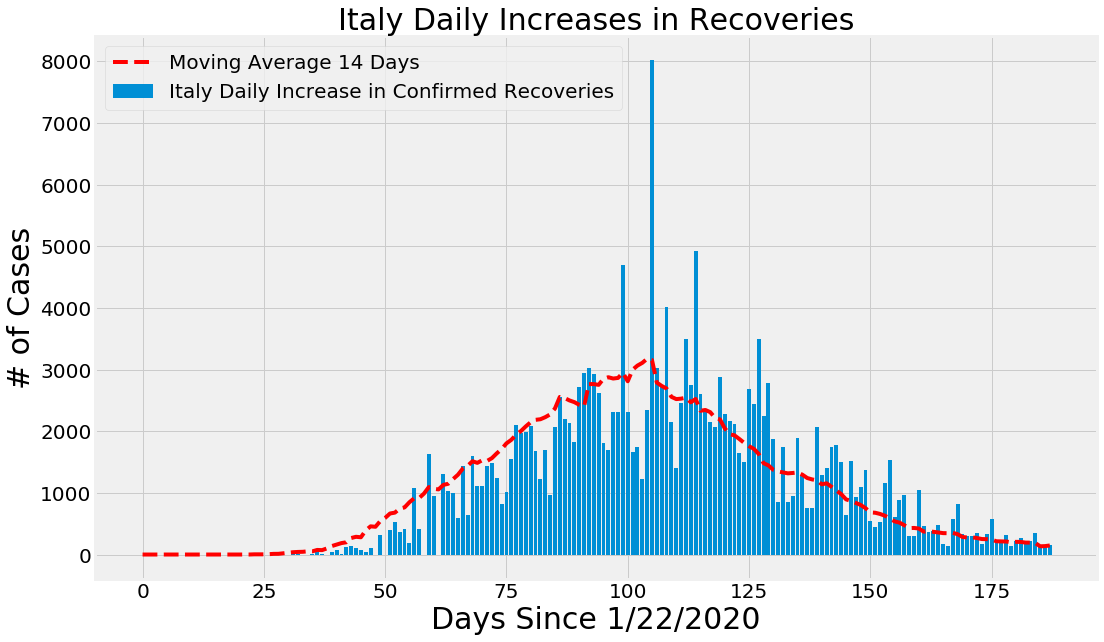

In [37]:
country_plot(adjusted_dates, italy_cases, italy_daily_increase, italy_daily_death, italy_daily_recovery, 'Italy')

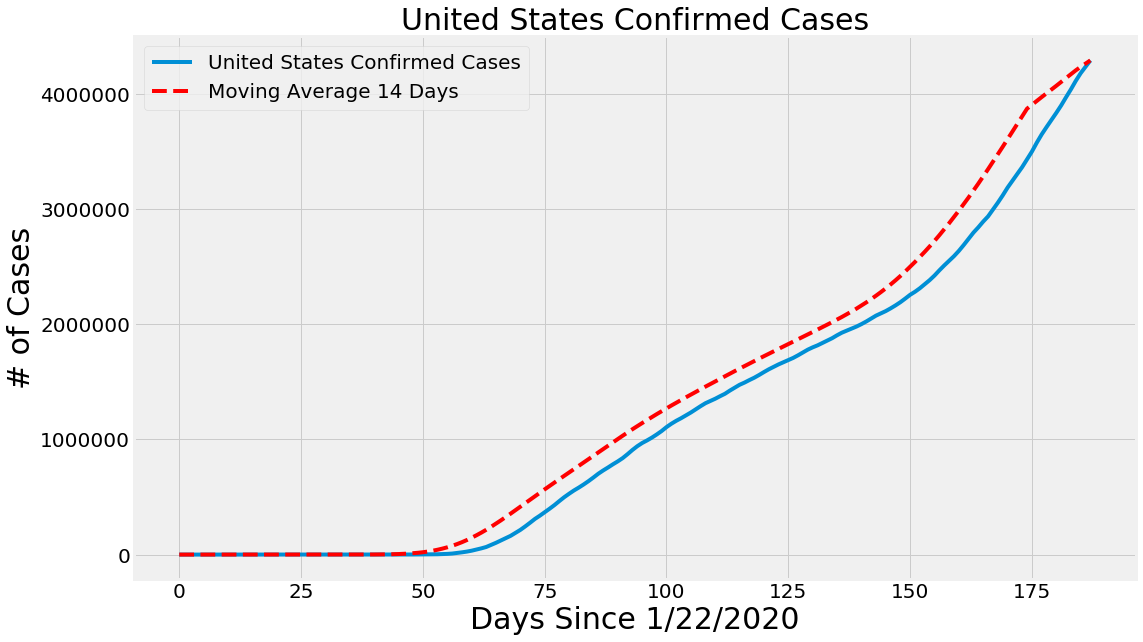

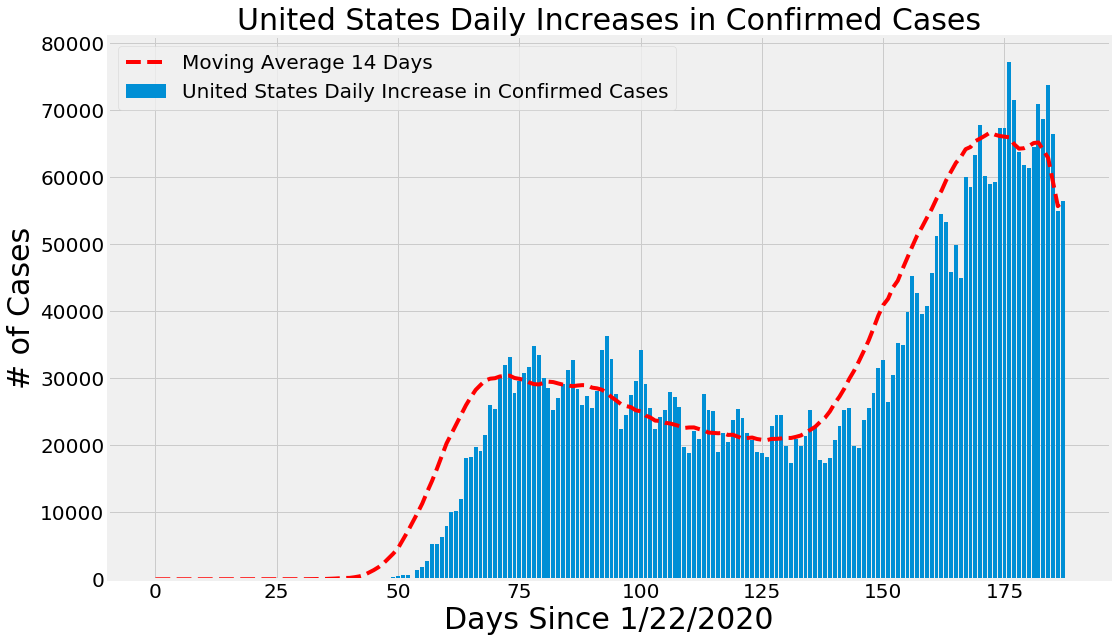

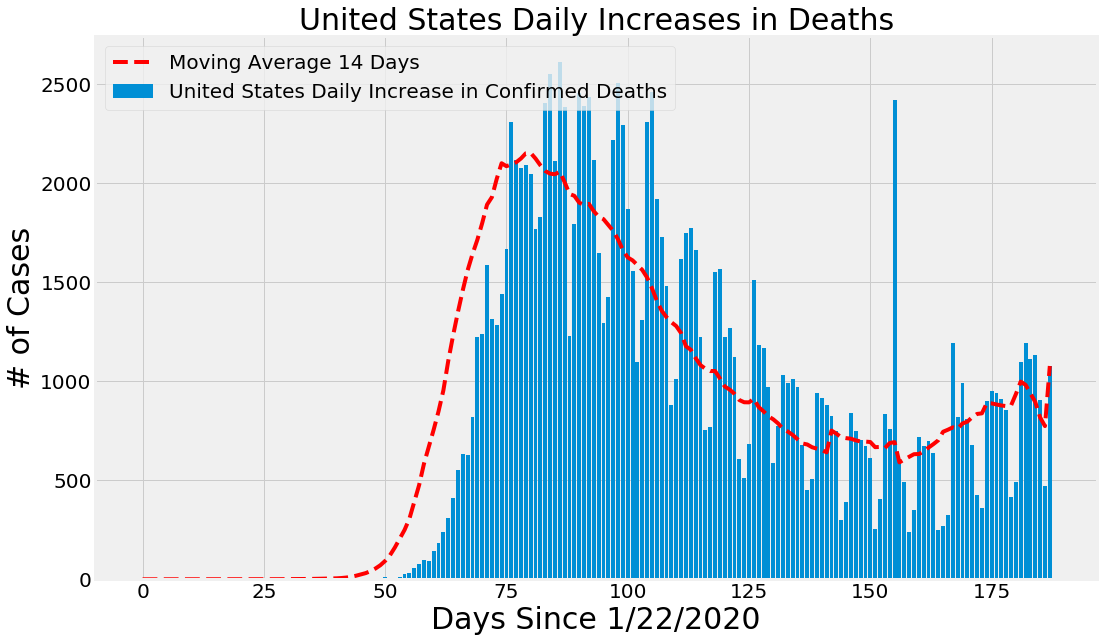

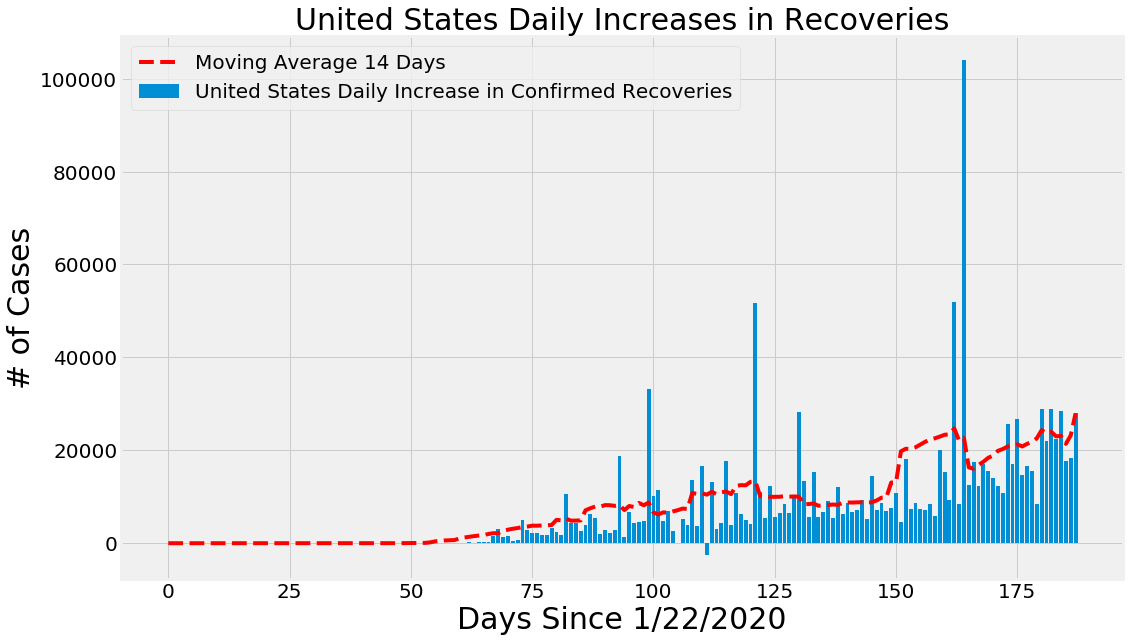

In [38]:
country_plot(adjusted_dates, us_cases, us_daily_increase, us_daily_death, us_daily_recovery, 'United States')

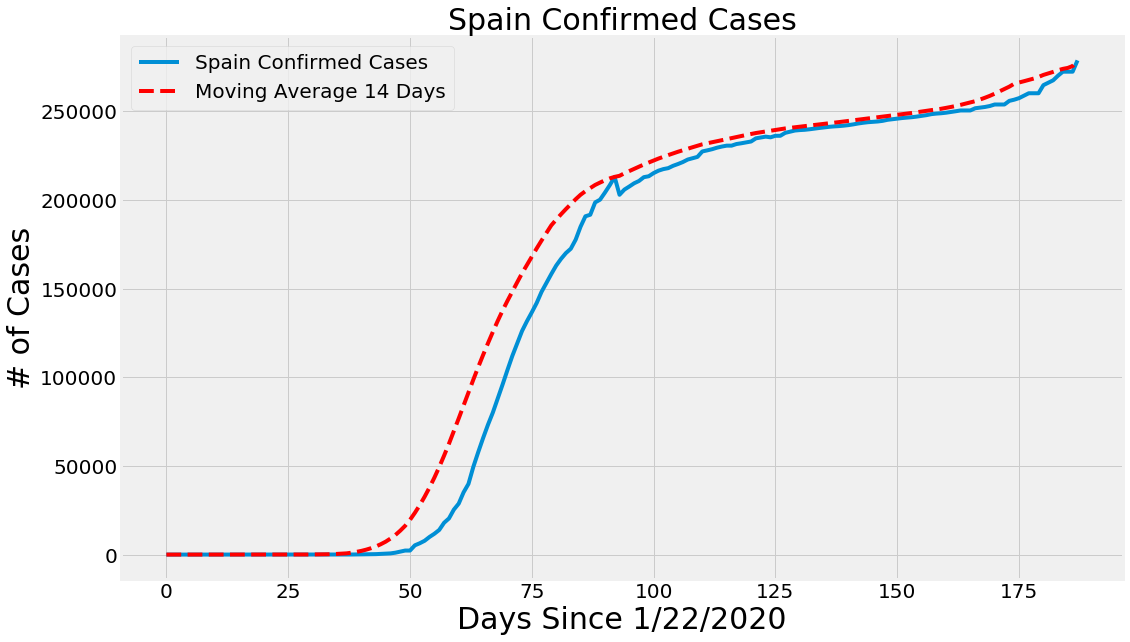

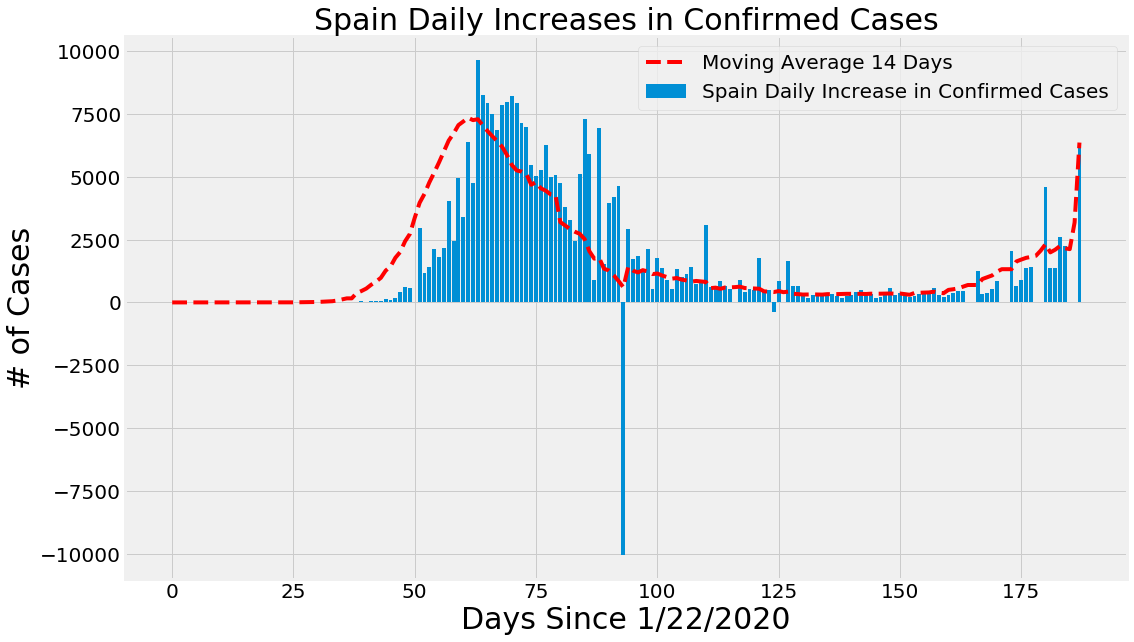

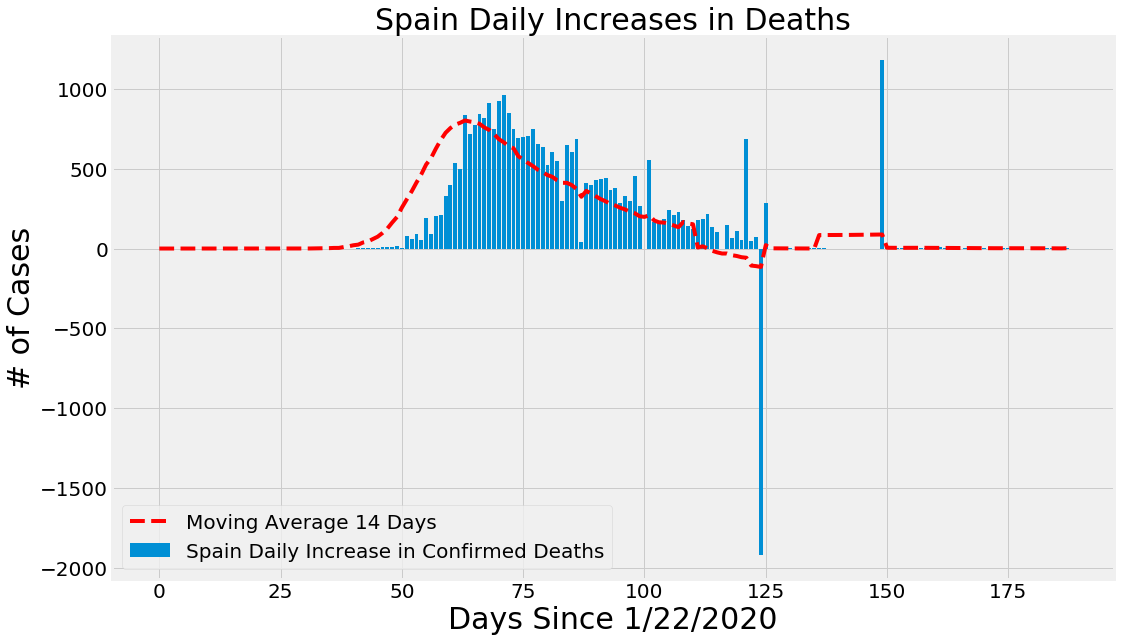

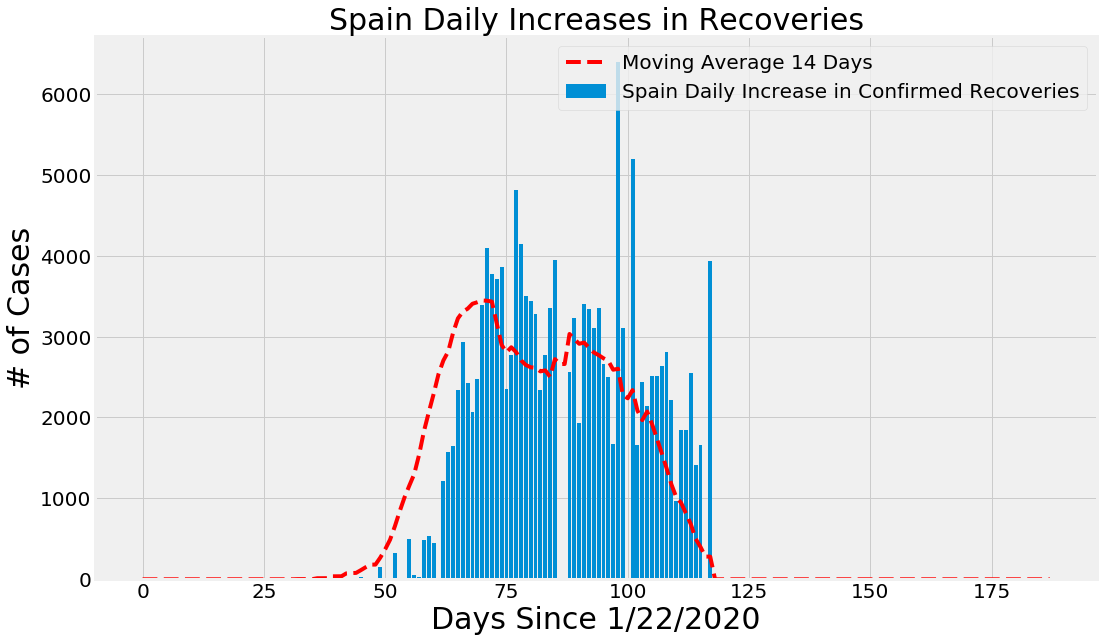

In [39]:
country_plot(adjusted_dates, spain_cases, spain_daily_increase, spain_daily_death, spain_daily_recovery, 'Spain')

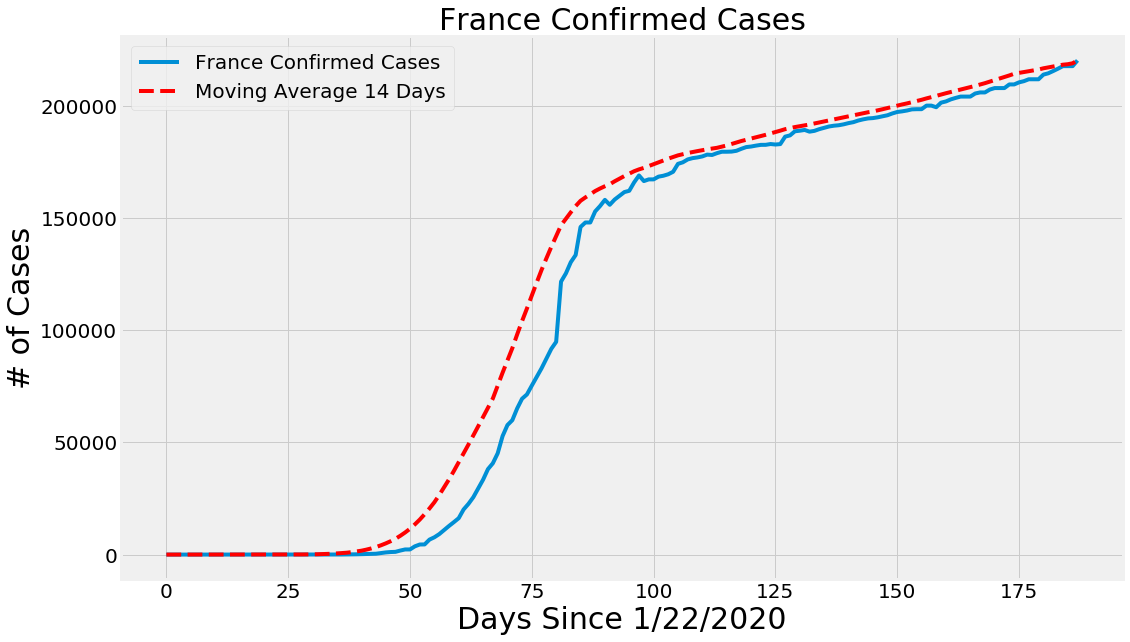

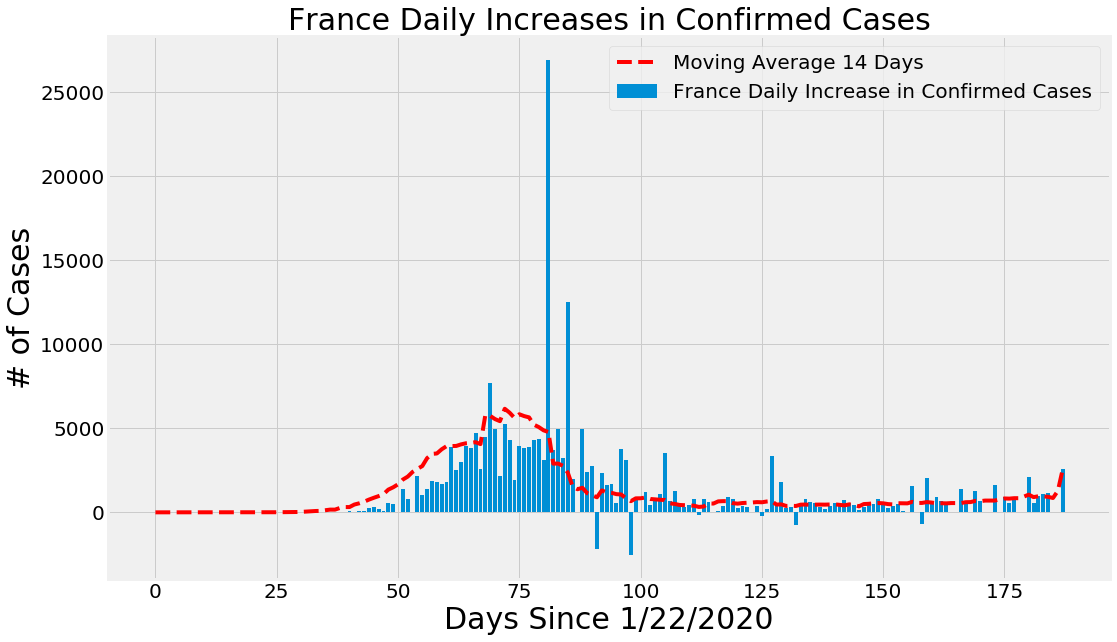

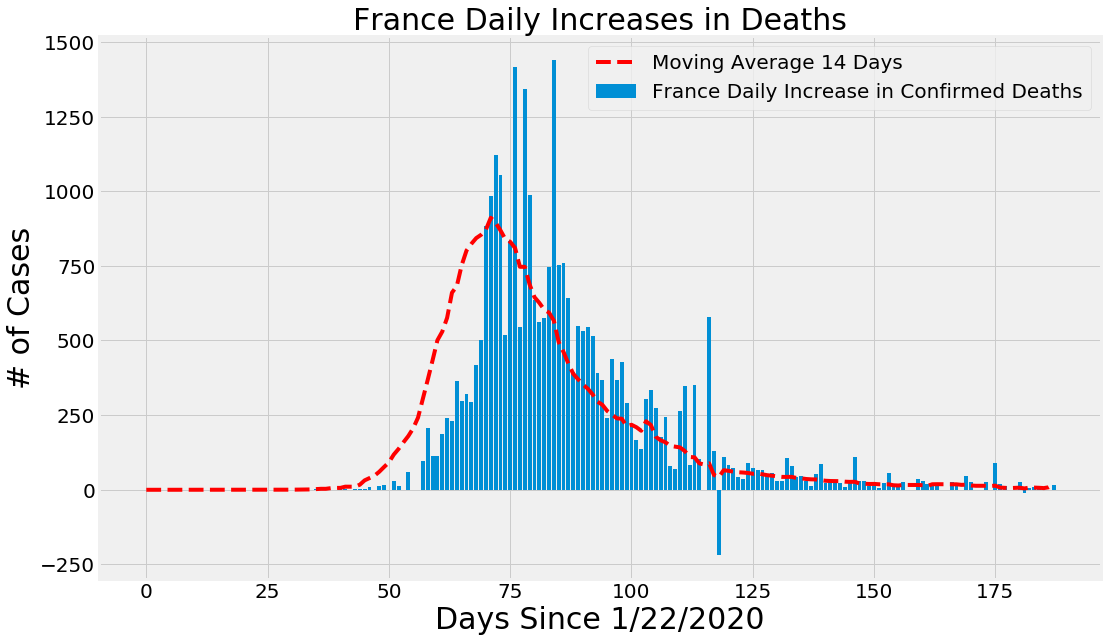

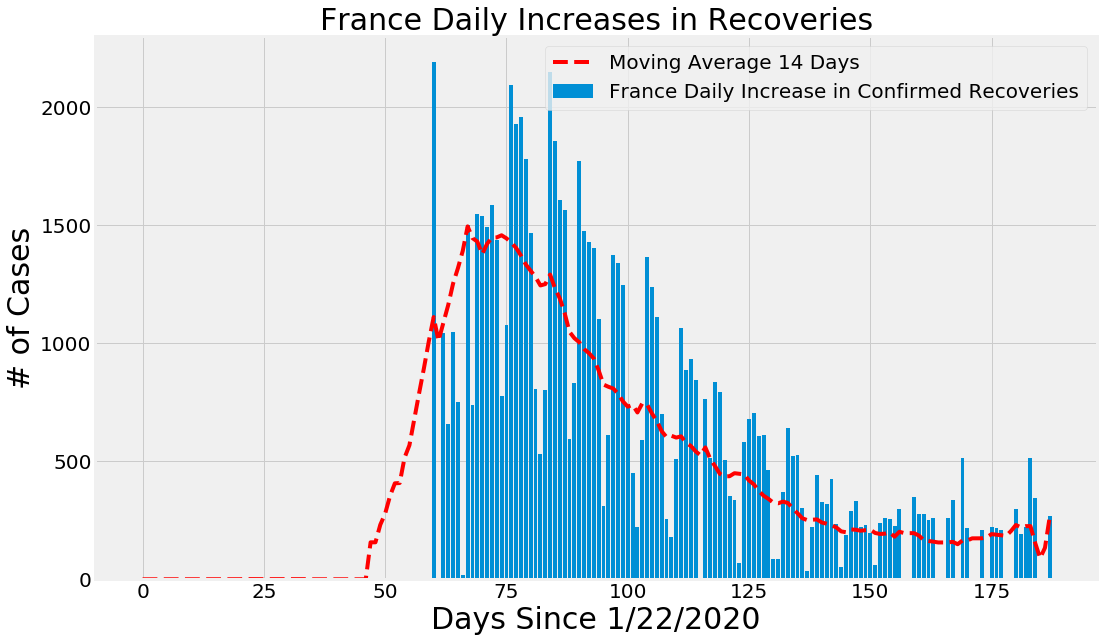

In [40]:
country_plot(adjusted_dates, france_cases, france_daily_increase, france_daily_death, france_daily_recovery, 'France')

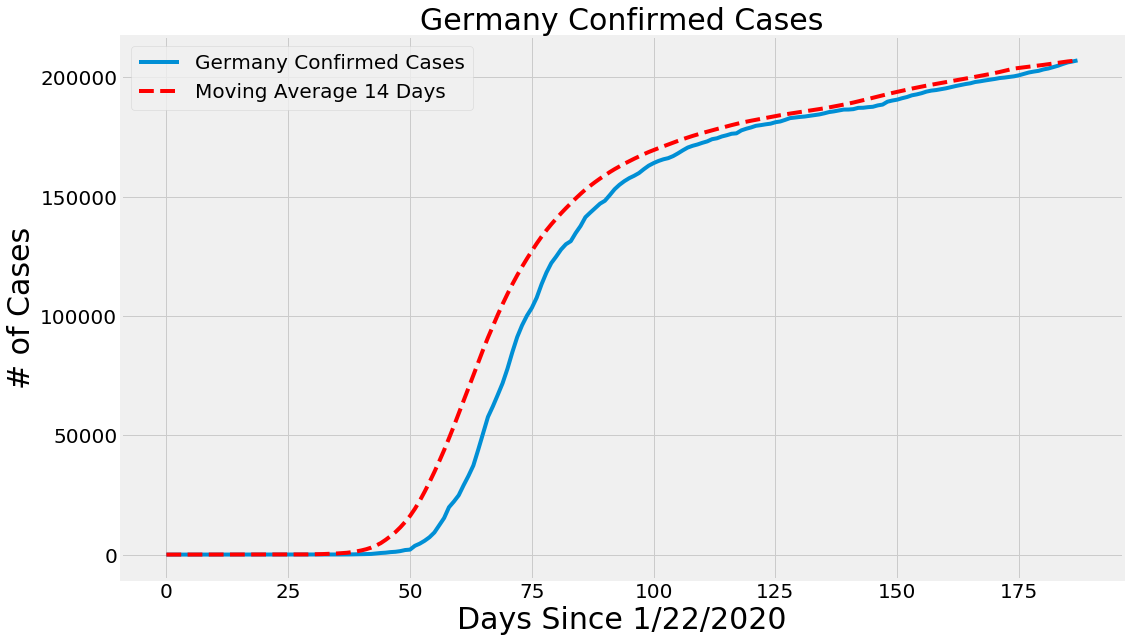

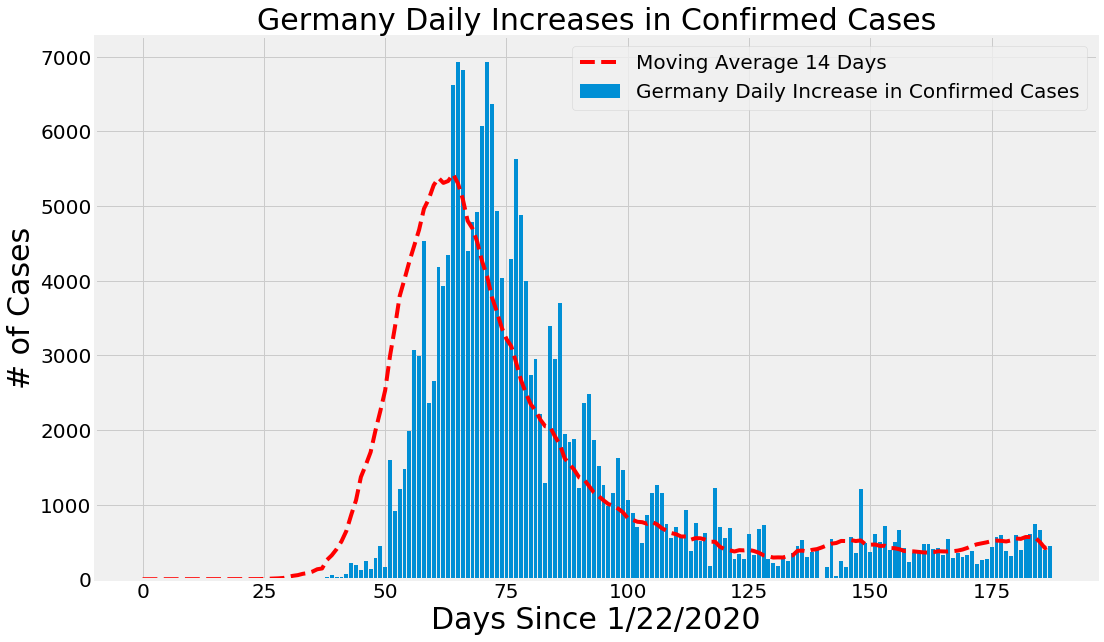

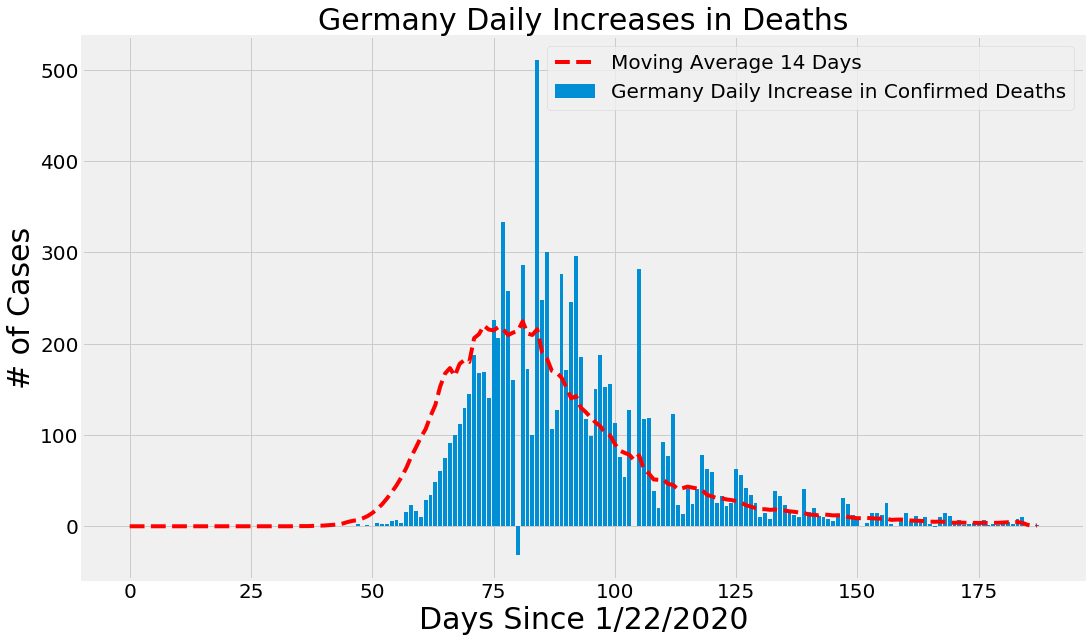

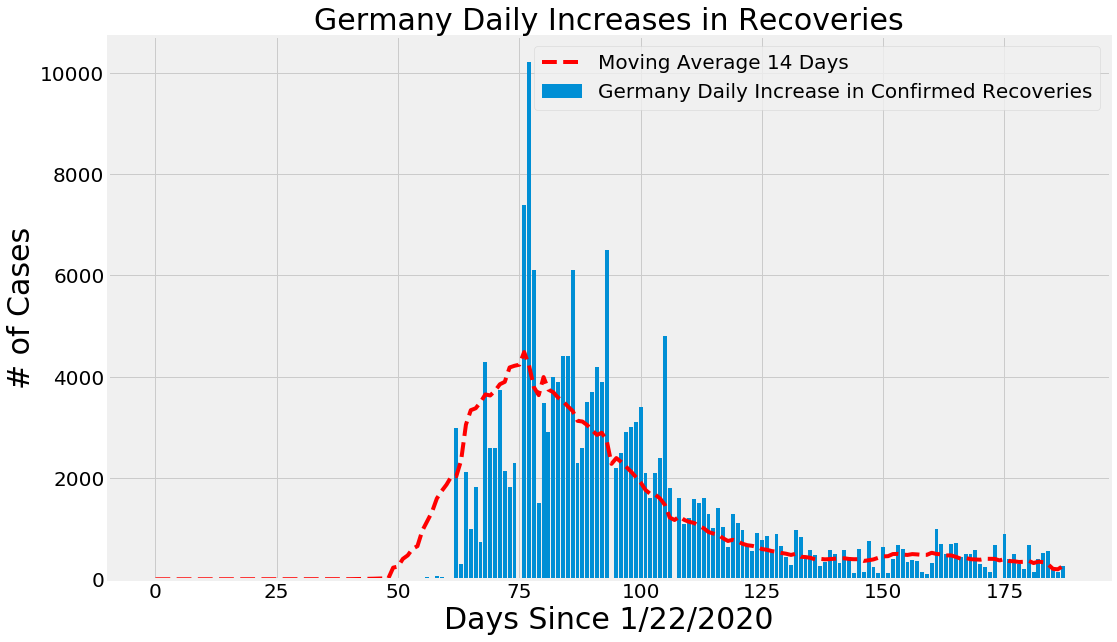

In [41]:
country_plot(adjusted_dates, germany_cases, germany_daily_increase, germany_daily_death, germany_daily_recovery, 'Germany')

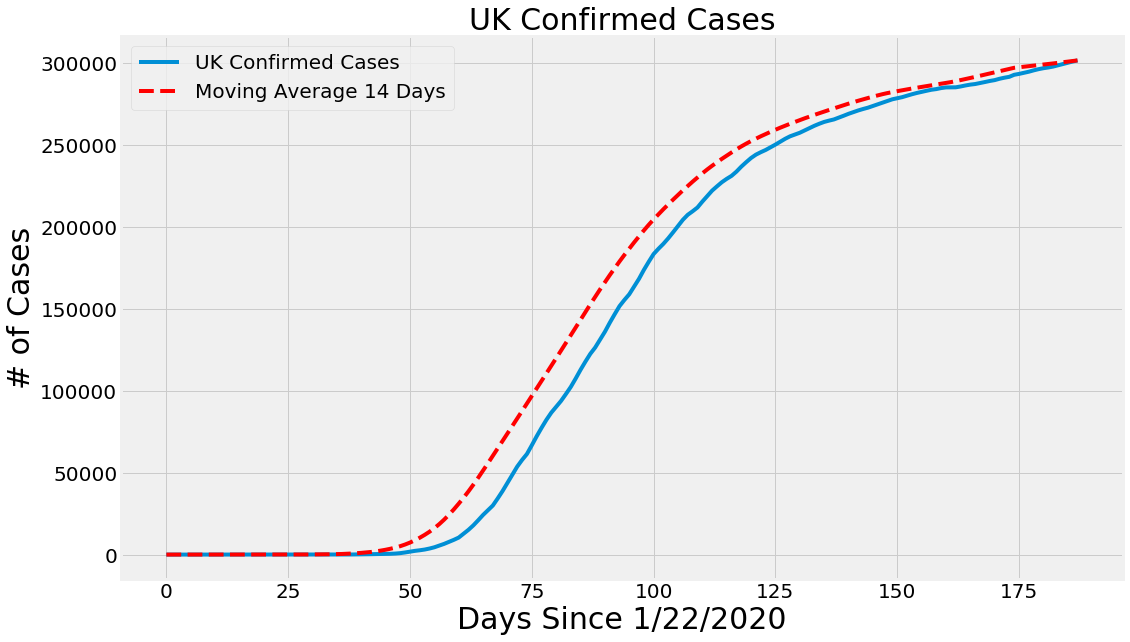

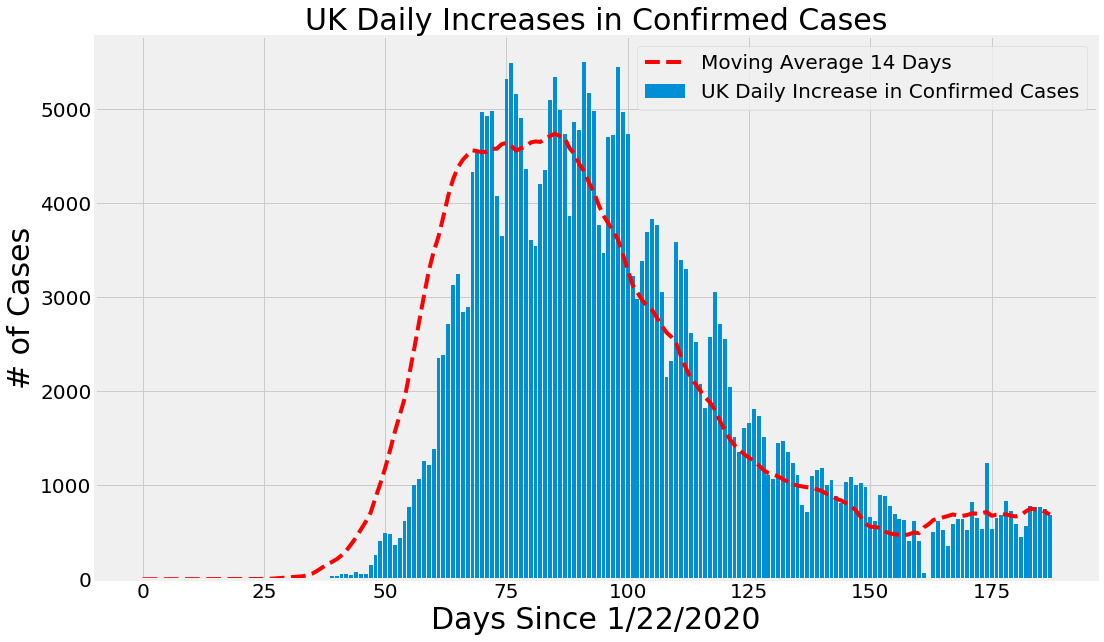

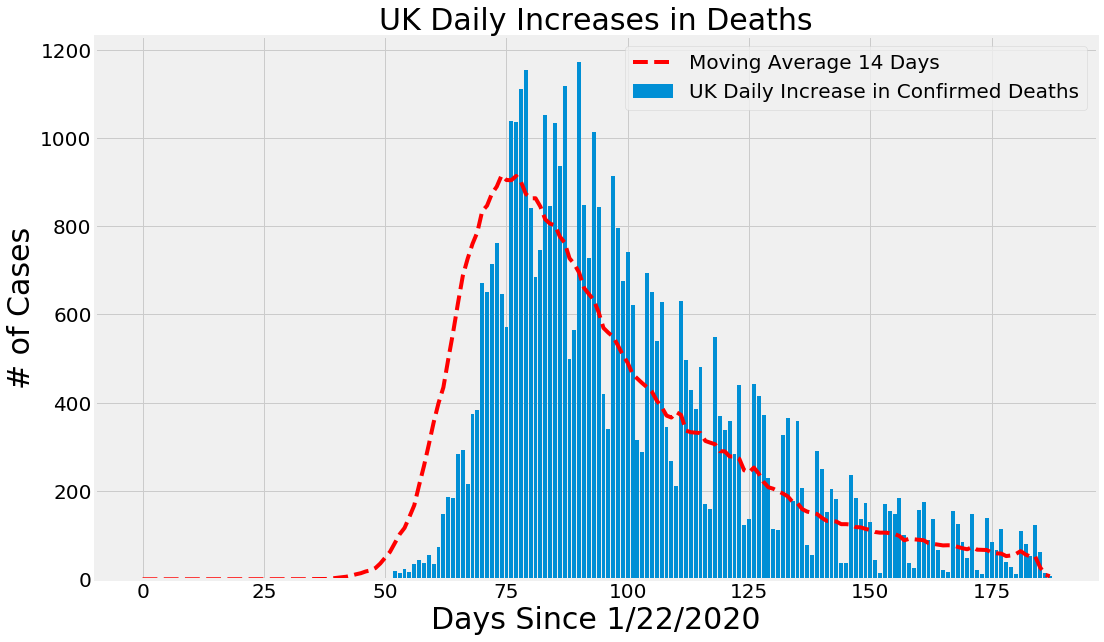

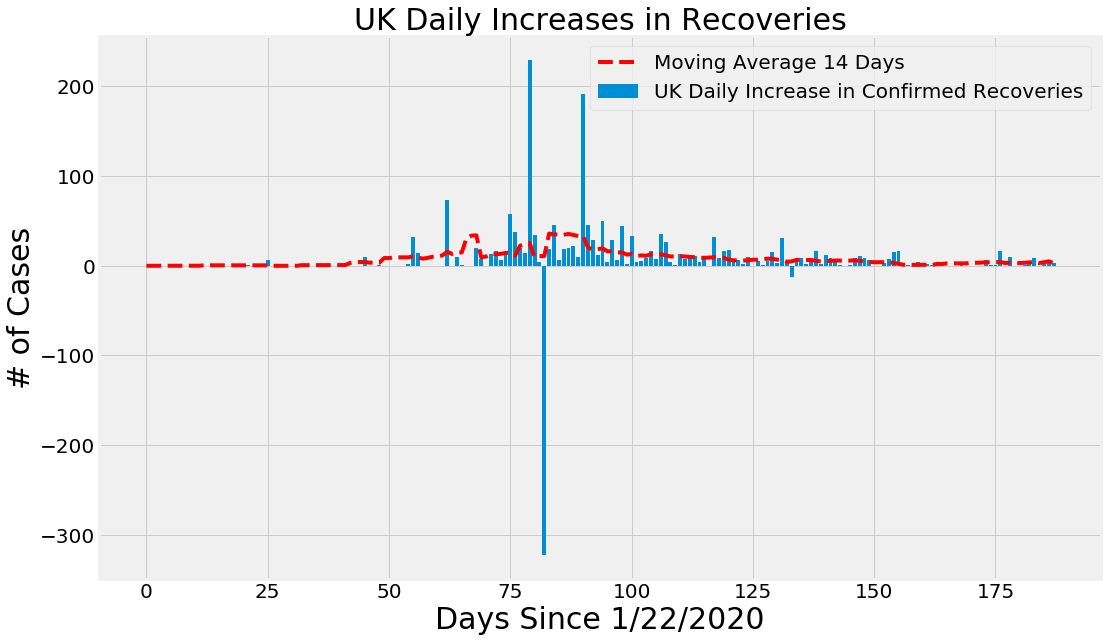

In [42]:
country_plot(adjusted_dates, uk_cases, uk_daily_increase, uk_daily_death, uk_daily_recovery, 'UK')

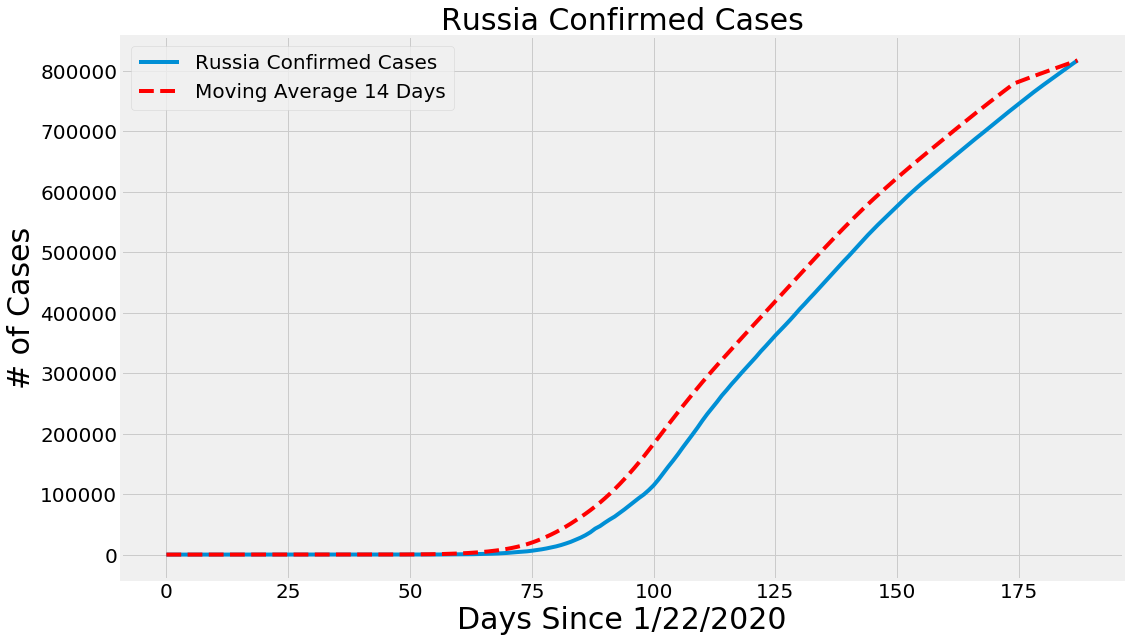

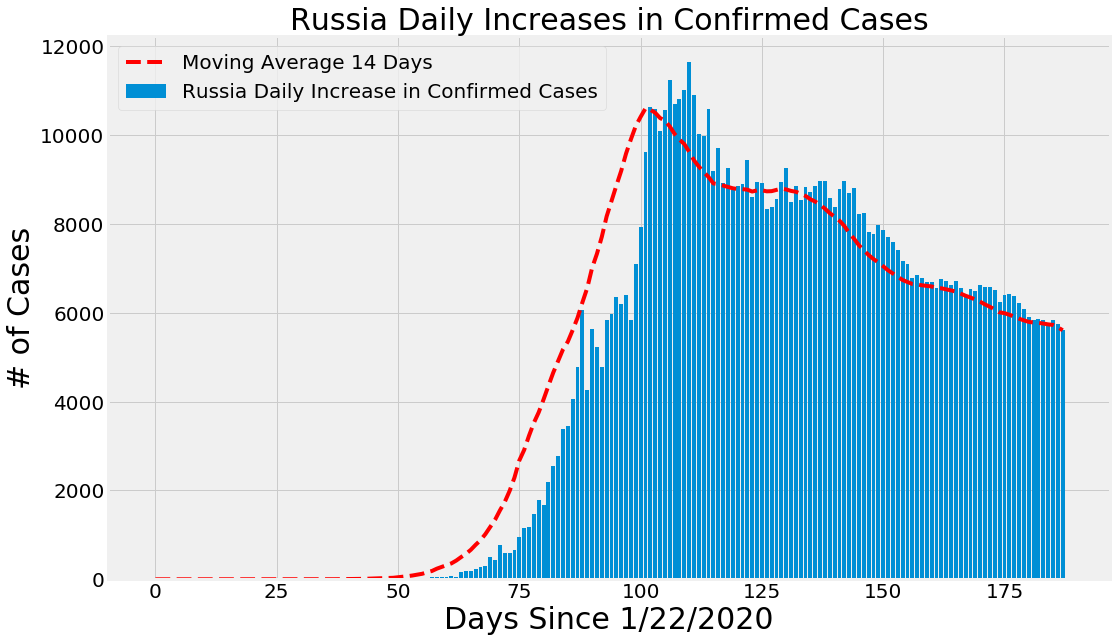

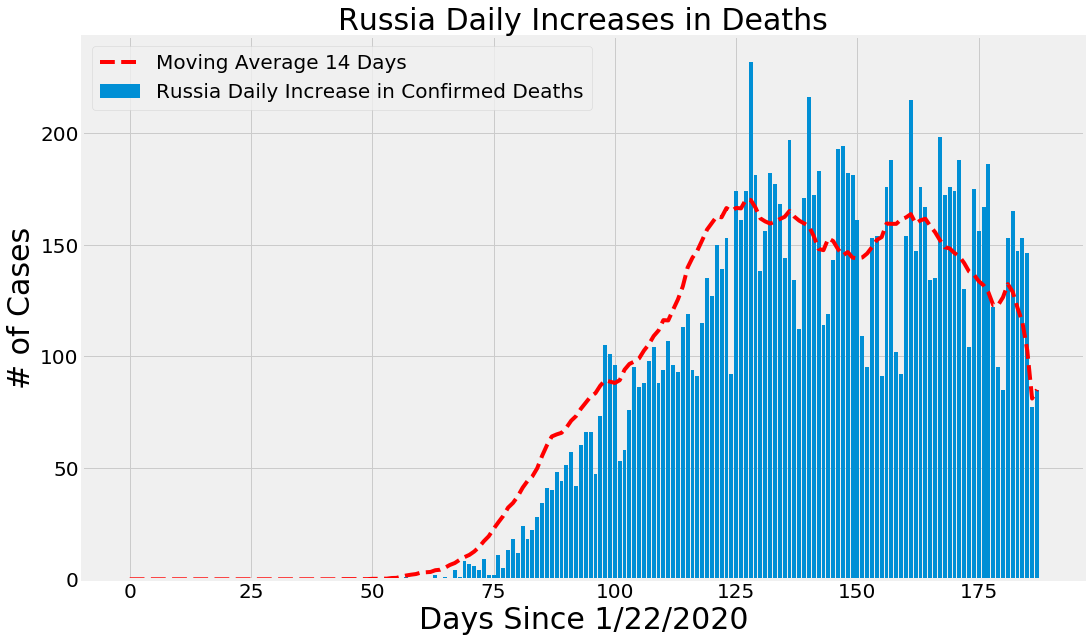

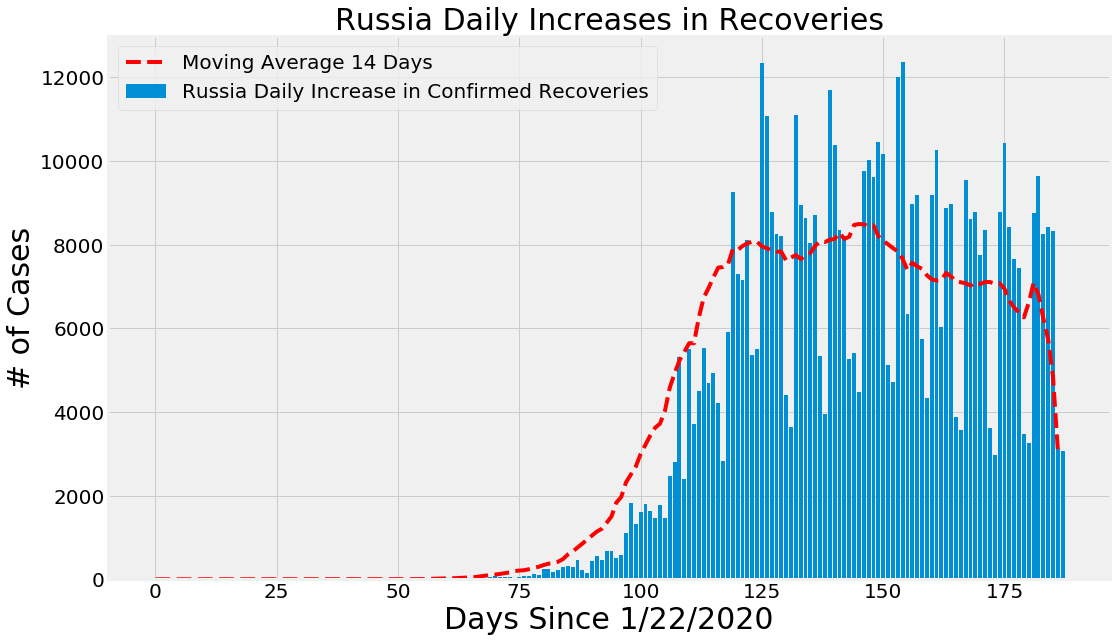

In [43]:
country_plot(adjusted_dates, russia_cases, russia_daily_increase, russia_daily_death, russia_daily_recovery, 'Russia')

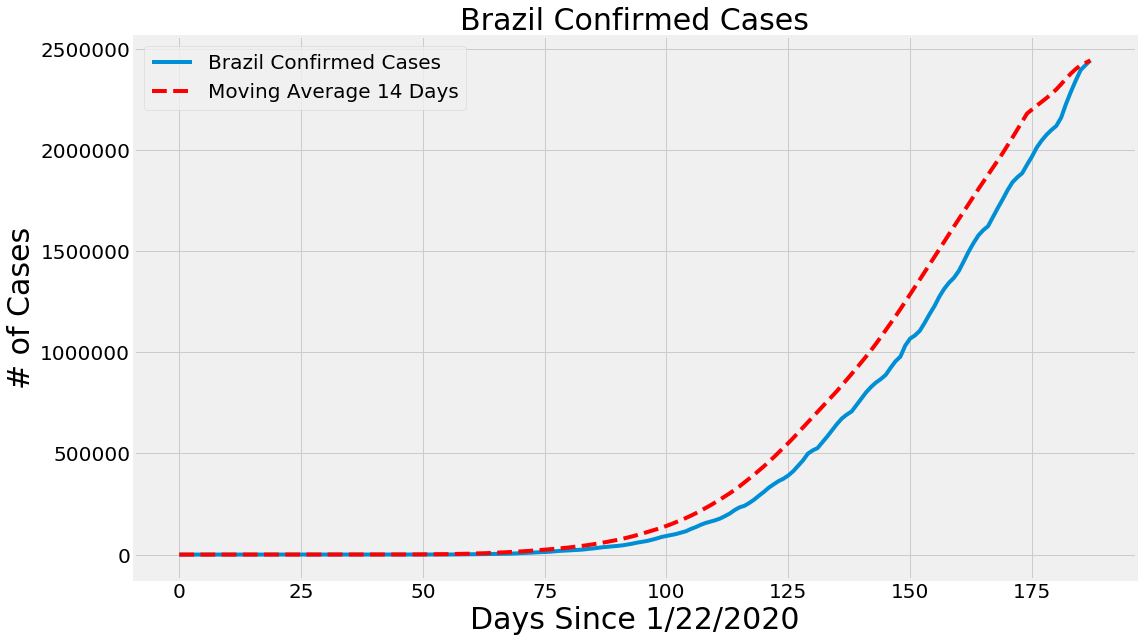

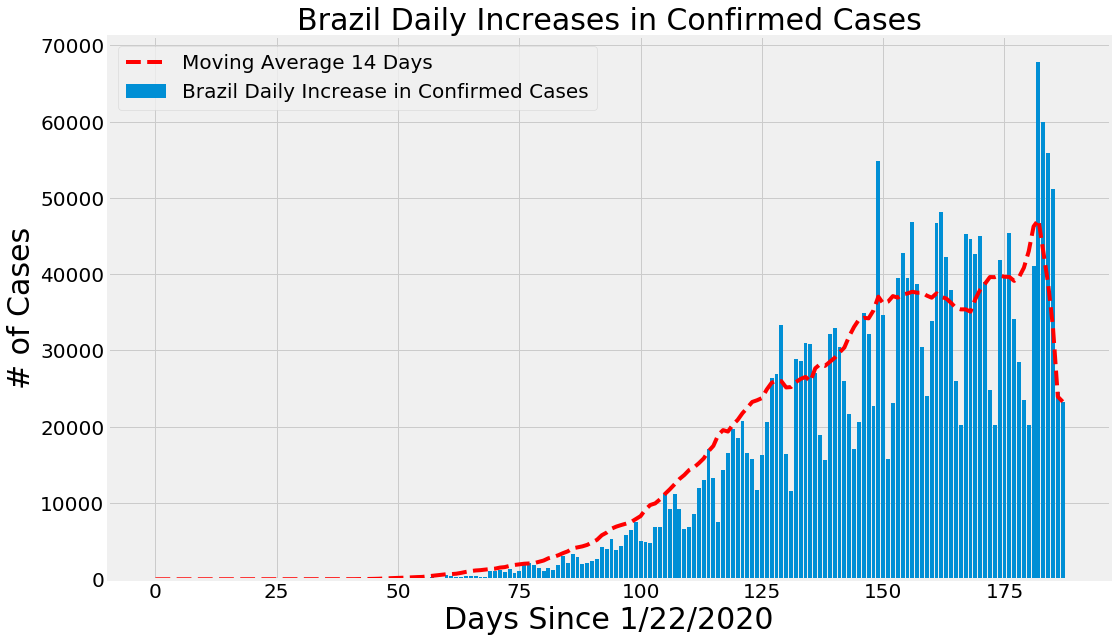

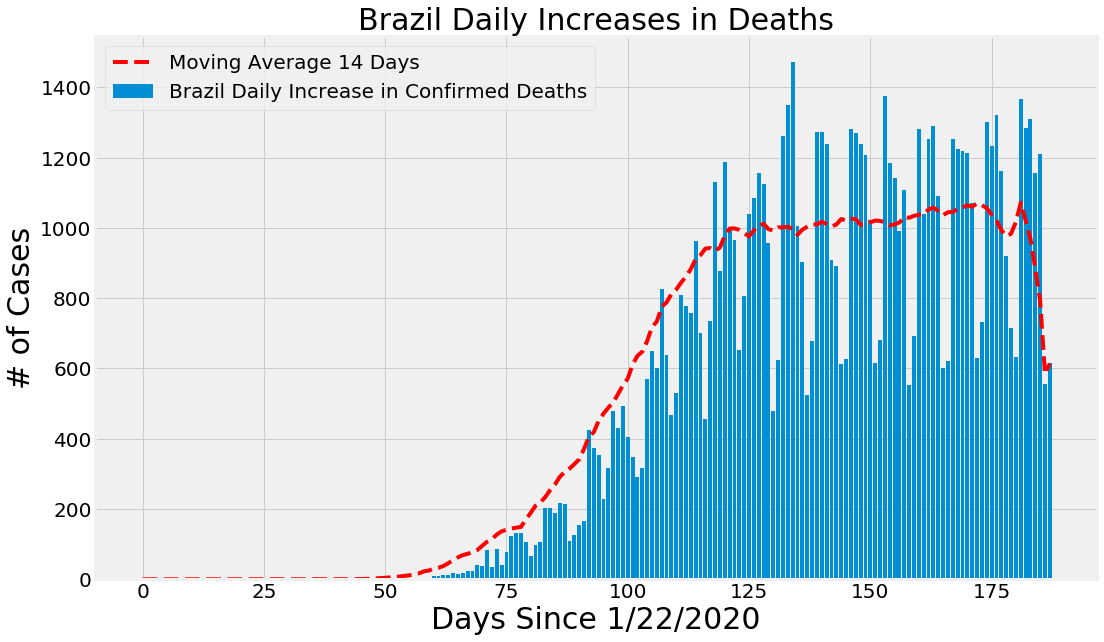

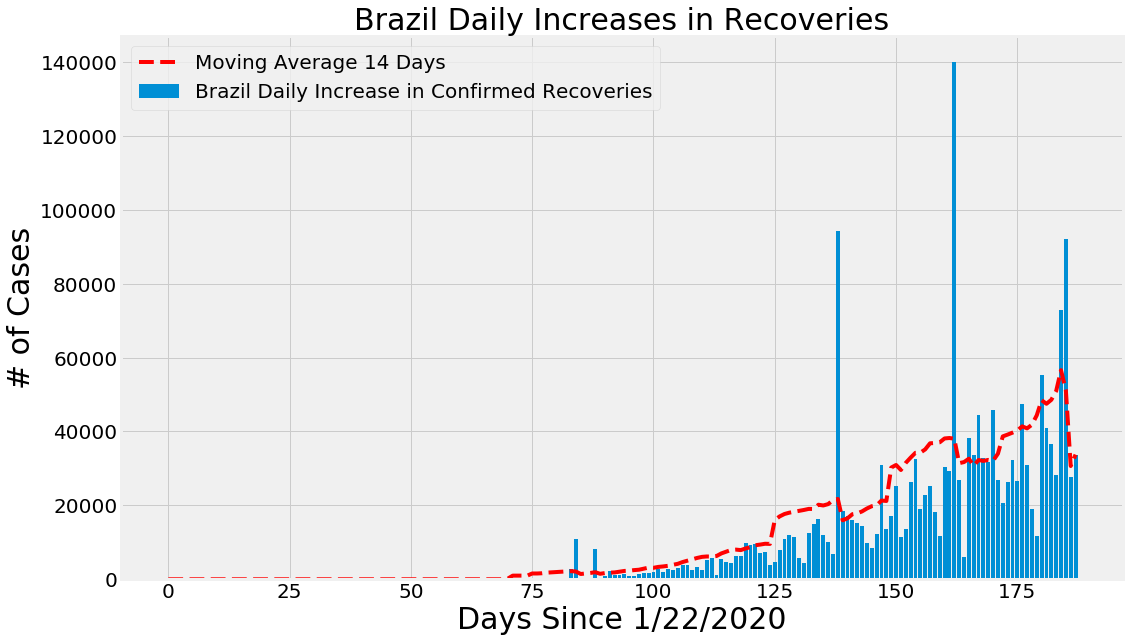

In [44]:
country_plot(adjusted_dates, brazil_cases, brazil_daily_increase, brazil_daily_death, brazil_daily_recovery, 'Brazil')

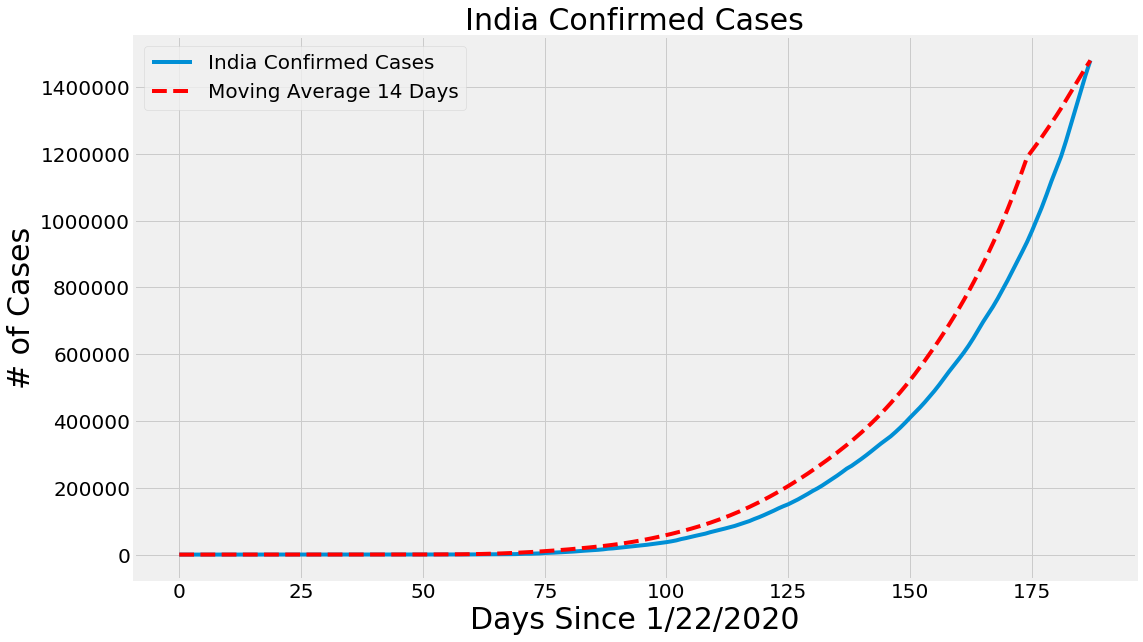

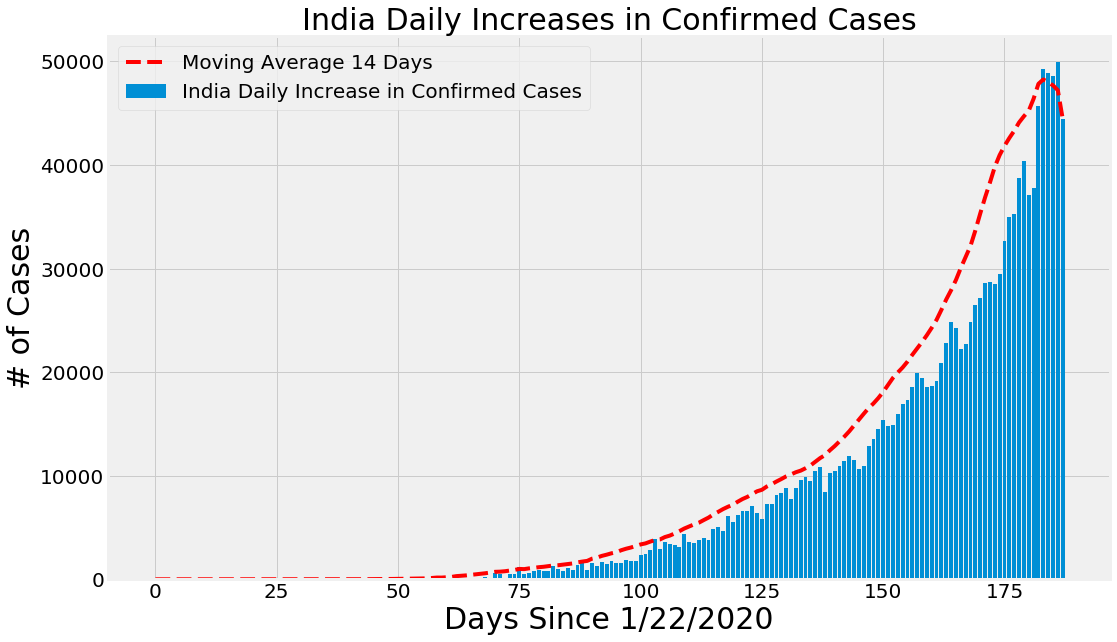

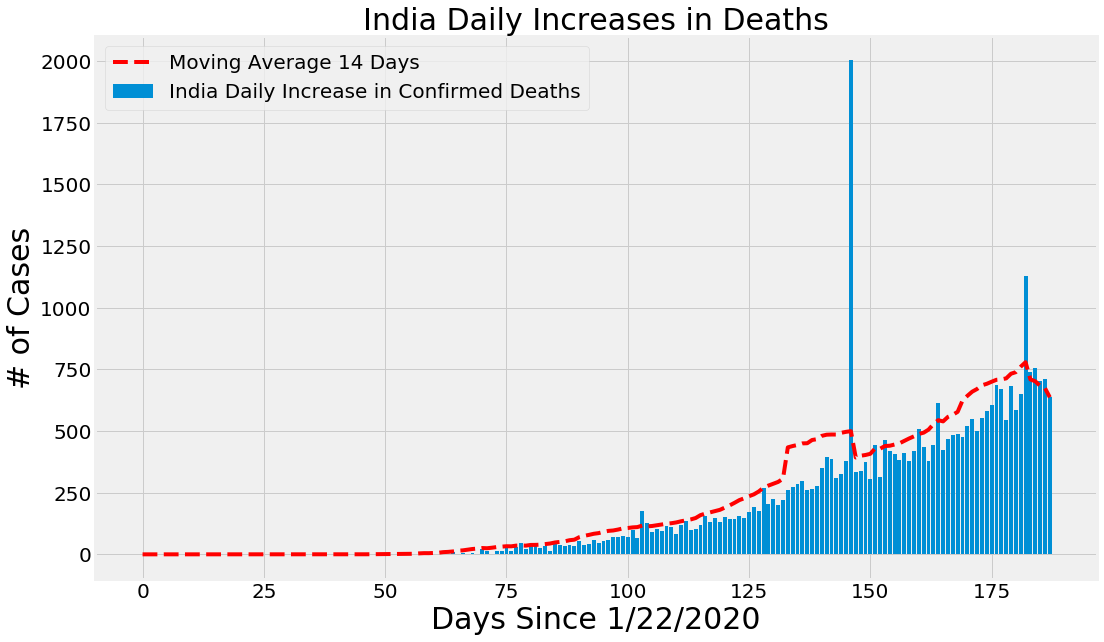

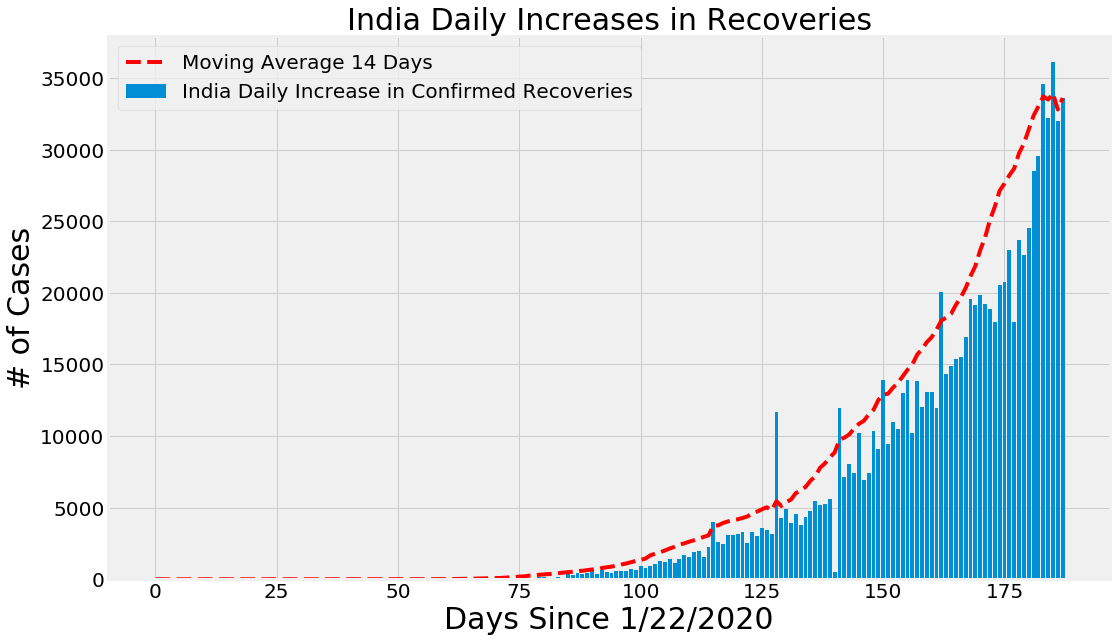

In [45]:
country_plot(adjusted_dates, india_cases, india_daily_increase, india_daily_death, india_daily_recovery, 'India')

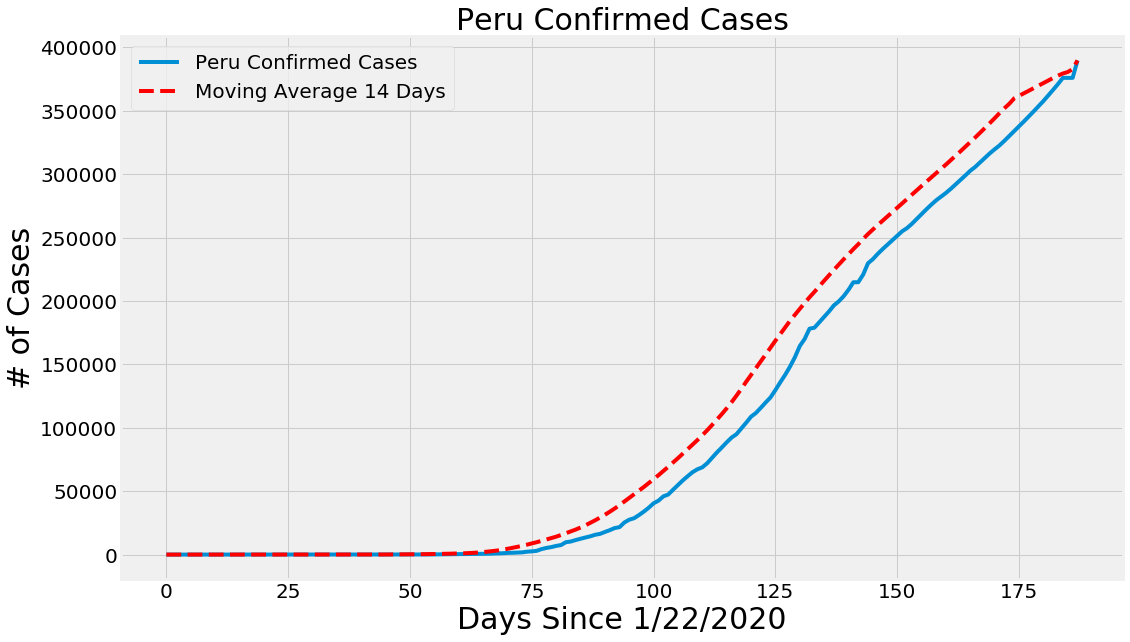

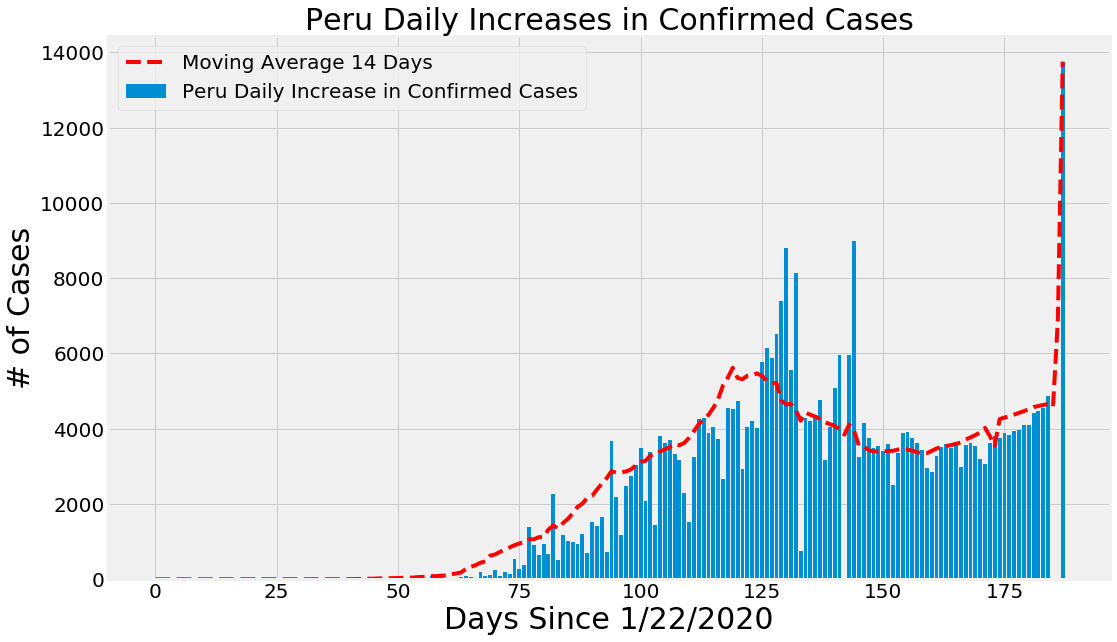

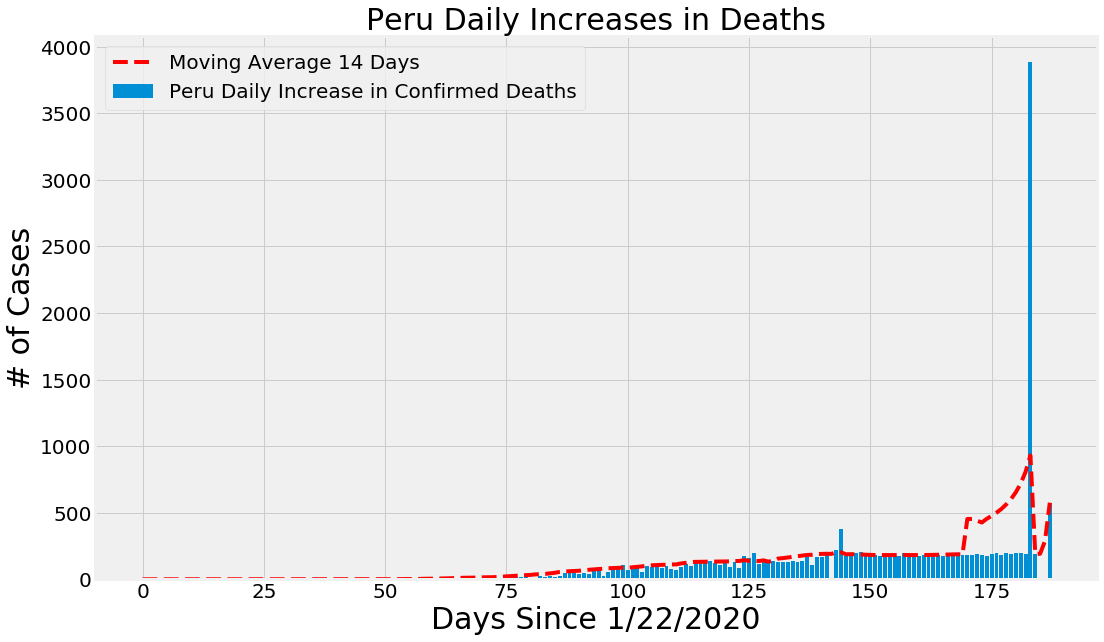

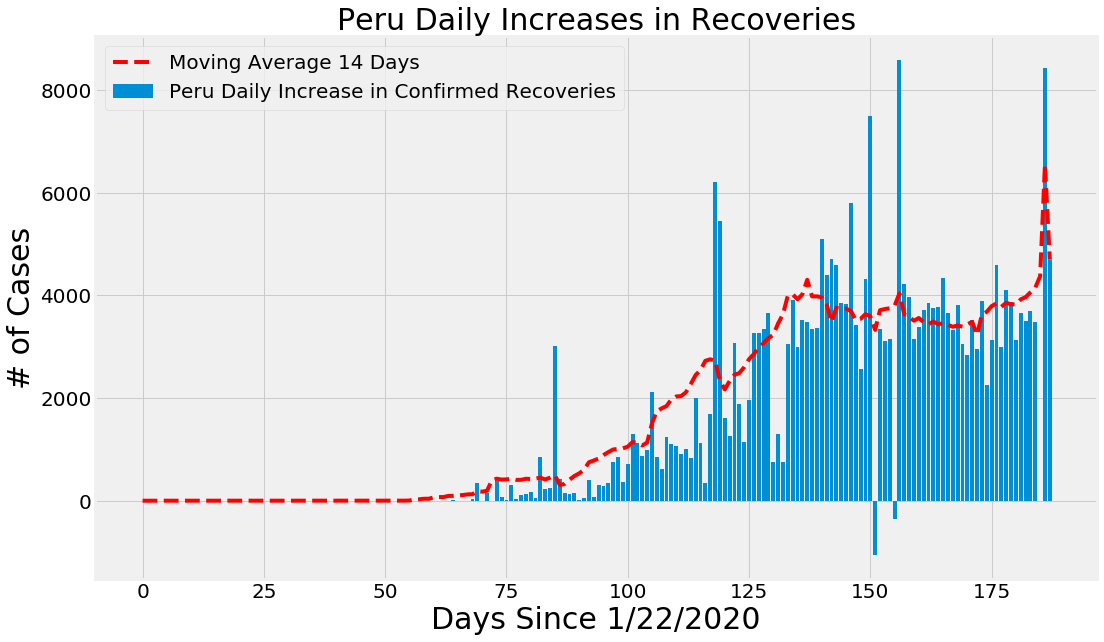

In [46]:
country_plot(adjusted_dates, peru_cases, peru_daily_increase, peru_daily_death, peru_daily_recovery, 'Peru')

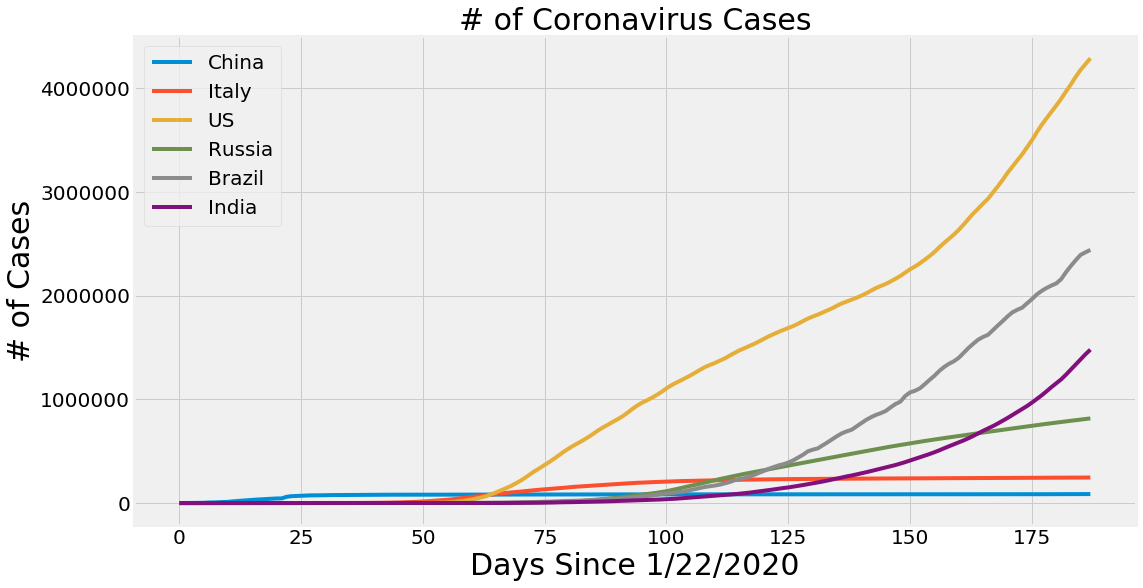

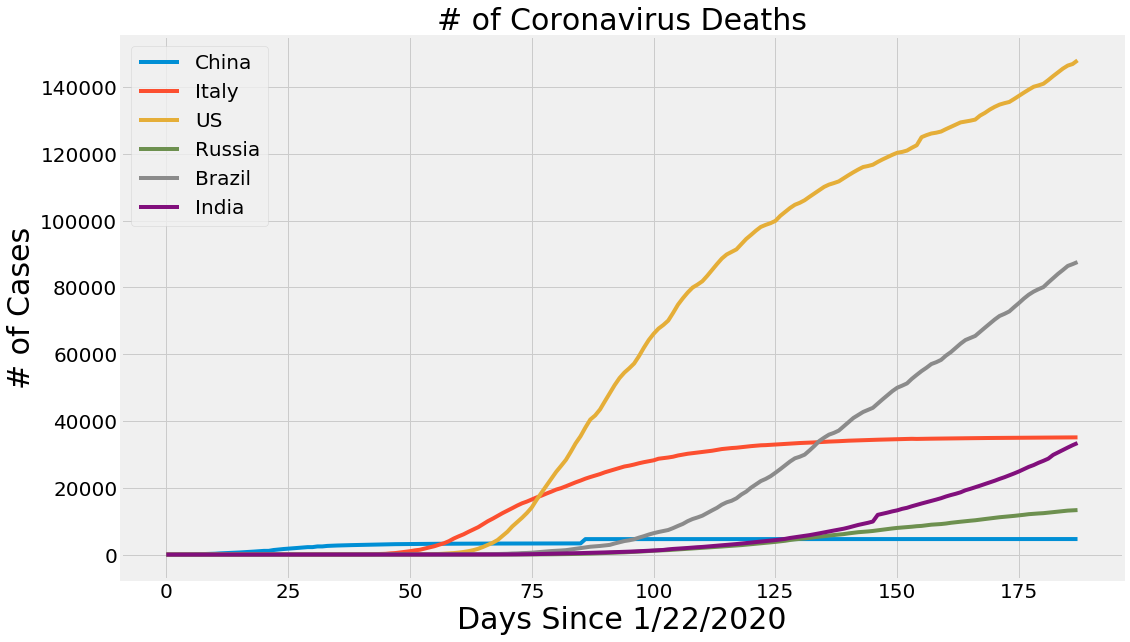

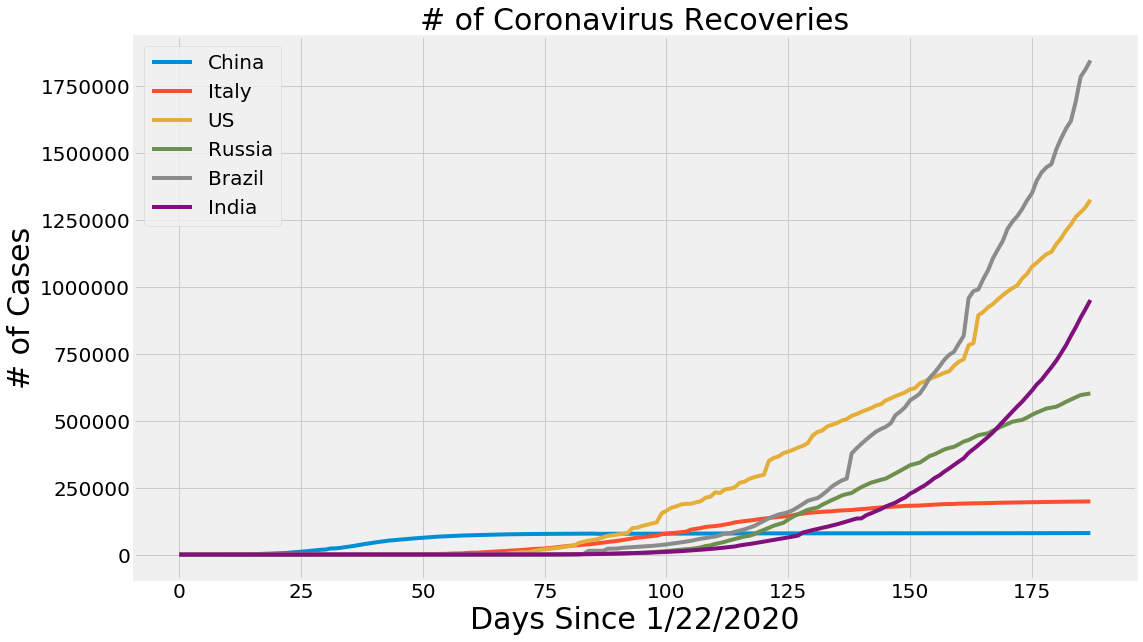

In [47]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, russia_cases)
plt.plot(adjusted_dates, brazil_cases)
plt.plot(adjusted_dates, india_cases)

plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Russia', 'Brazil', 'India'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, china_deaths)
plt.plot(adjusted_dates, italy_deaths)
plt.plot(adjusted_dates, us_deaths)
plt.plot(adjusted_dates, russia_deaths)
plt.plot(adjusted_dates, brazil_deaths)
plt.plot(adjusted_dates, india_deaths)

plt.title('# of Coronavirus Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Russia', 'Brazil', 'India'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, china_recoveries)
plt.plot(adjusted_dates, italy_recoveries)
plt.plot(adjusted_dates, us_recoveries)
plt.plot(adjusted_dates, russia_recoveries)
plt.plot(adjusted_dates, brazil_recoveries)
plt.plot(adjusted_dates, india_recoveries)

plt.title('# of Coronavirus Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Russia', 'Brazil', 'India'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [48]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

## Predictions for confirmed coronavirus cases worldwide

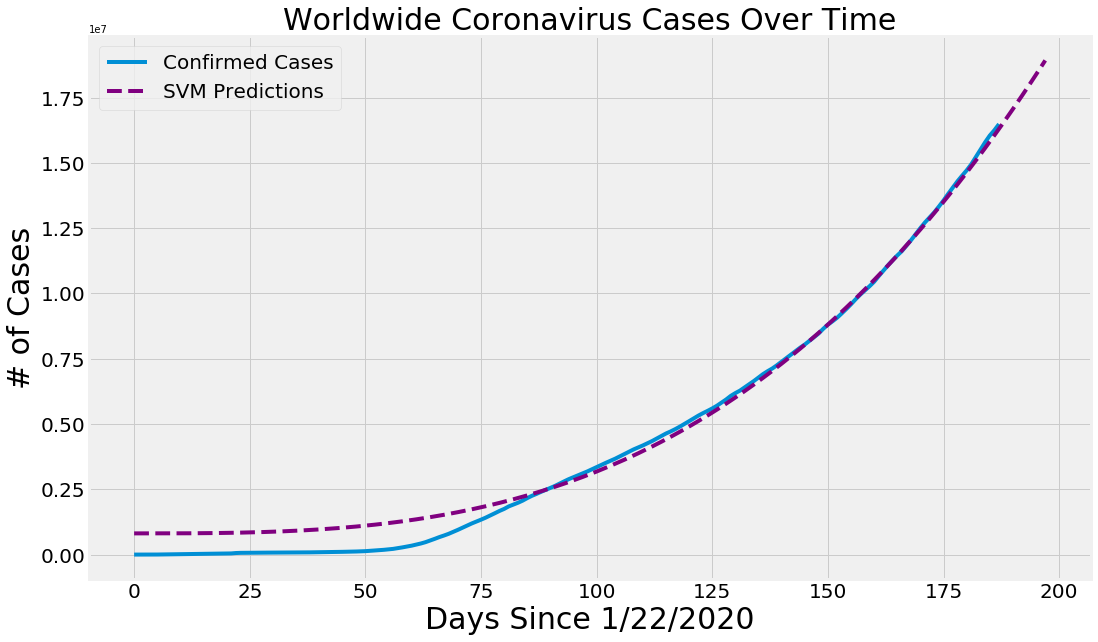

In [50]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

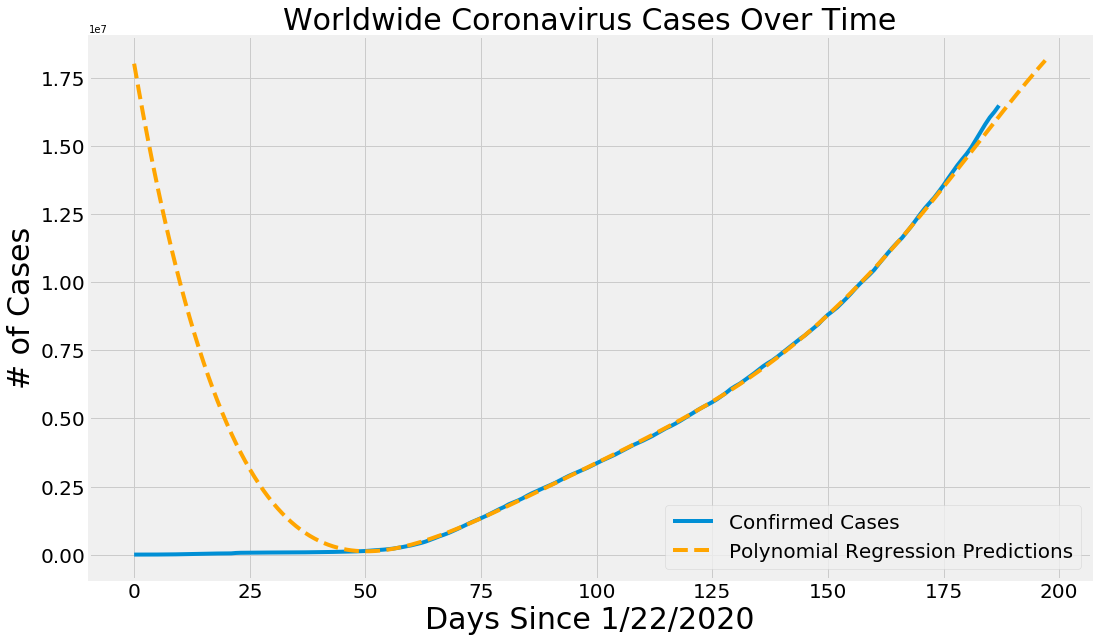

In [51]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

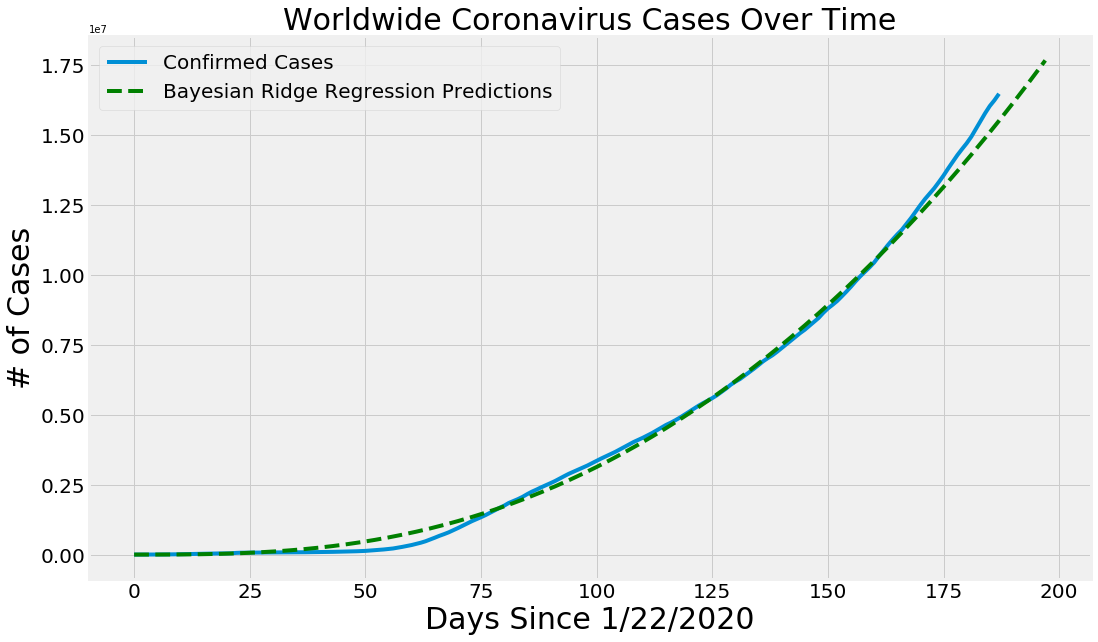

In [52]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [53]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

Date  SVM Predicted # of Confirmed Cases Worldwide
0  07/28/2020                                    16555484.0
1  07/29/2020                                    16808037.0
2  07/30/2020                                    17063278.0
3  07/31/2020                                    17321219.0
4  08/01/2020                                    17581875.0
5  08/02/2020                                    17845261.0
6  08/03/2020                                    18111390.0
7  08/04/2020                                    18380278.0
8  08/05/2020                                    18651937.0
9  08/06/2020                                    18926382.0

In [54]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
svm_df

Date  Polynomial Predicted # of Confirmed Cases Worldwide
0  07/28/2020                                         16304800.0  
1  07/29/2020                                         16518022.0  
2  07/30/2020                                         16729683.0  
3  07/31/2020                                         16939514.0  
4  08/01/2020                                         17147238.0  
5  08/02/2020                                         17352565.0  
6  08/03/2020                                         17555199.0  
7  08/04/2020                                         17754830.0  
8  08/05/2020                                         17951139.0  
9  08/06/2020                                         18143795.0

In [55]:
# Future predictions using Bayesian Ridge 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
svm_df

Date  Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0  07/28/2020                                         15729115.0      
1  07/29/2020                                         15939079.0      
2  07/30/2020                                         16150754.0      
3  07/31/2020                                         16364152.0      
4  08/01/2020                                         16579283.0      
5  08/02/2020                                         16796159.0      
6  08/03/2020                                         17014792.0      
7  08/04/2020                                         17235192.0      
8  08/05/2020                                         17457372.0      
9  08/06/2020                                         17681345.0

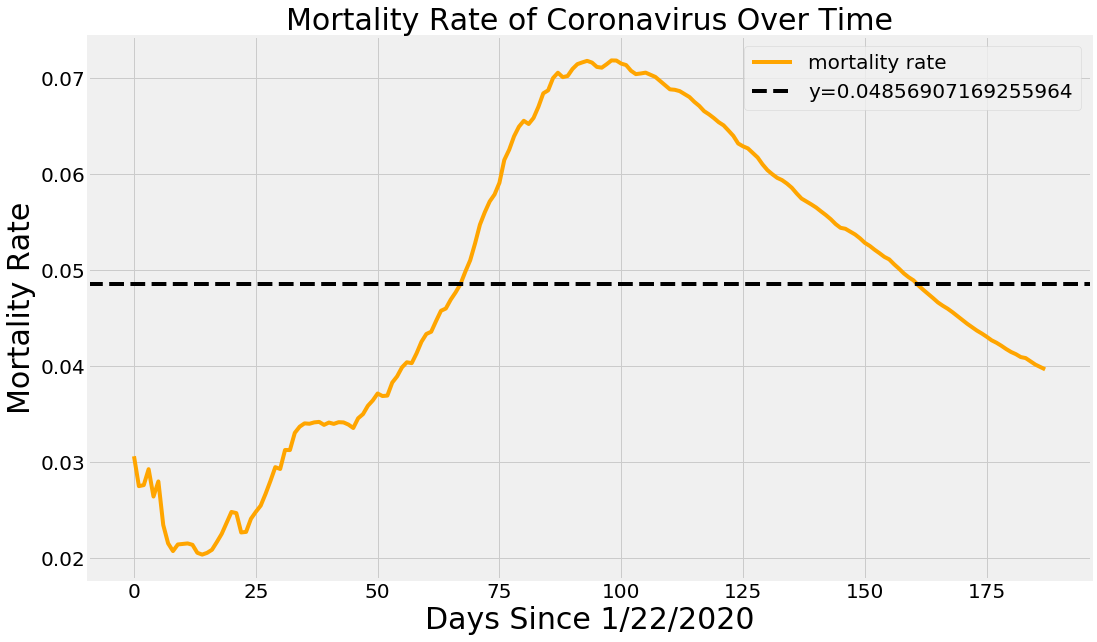

In [56]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Recovery Rate (worldwide) **suceptible to change**

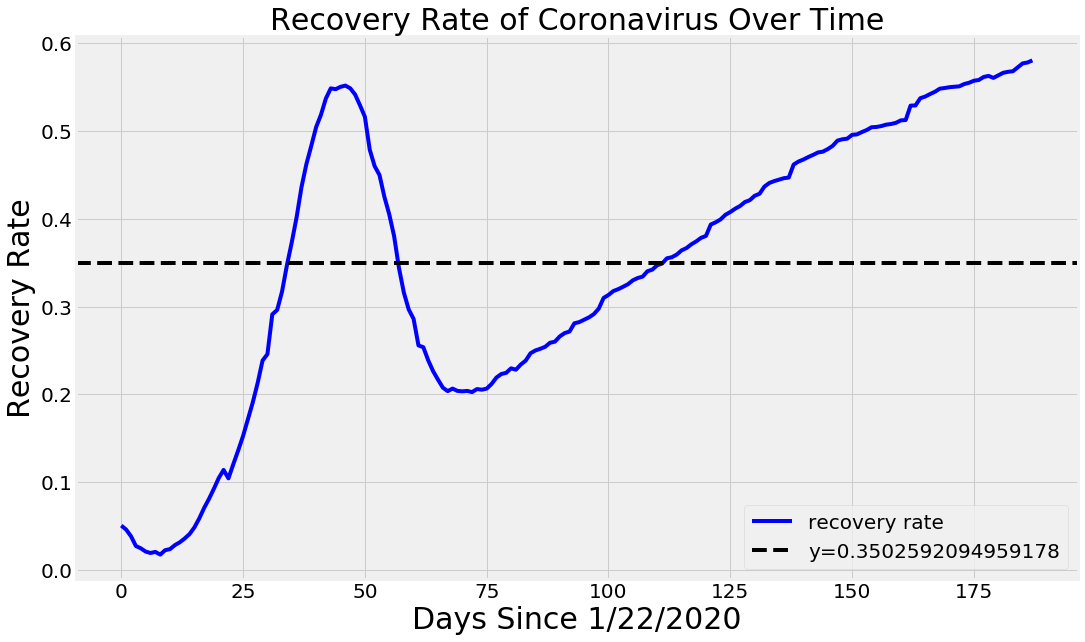

In [57]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Graphing deaths against recoveries

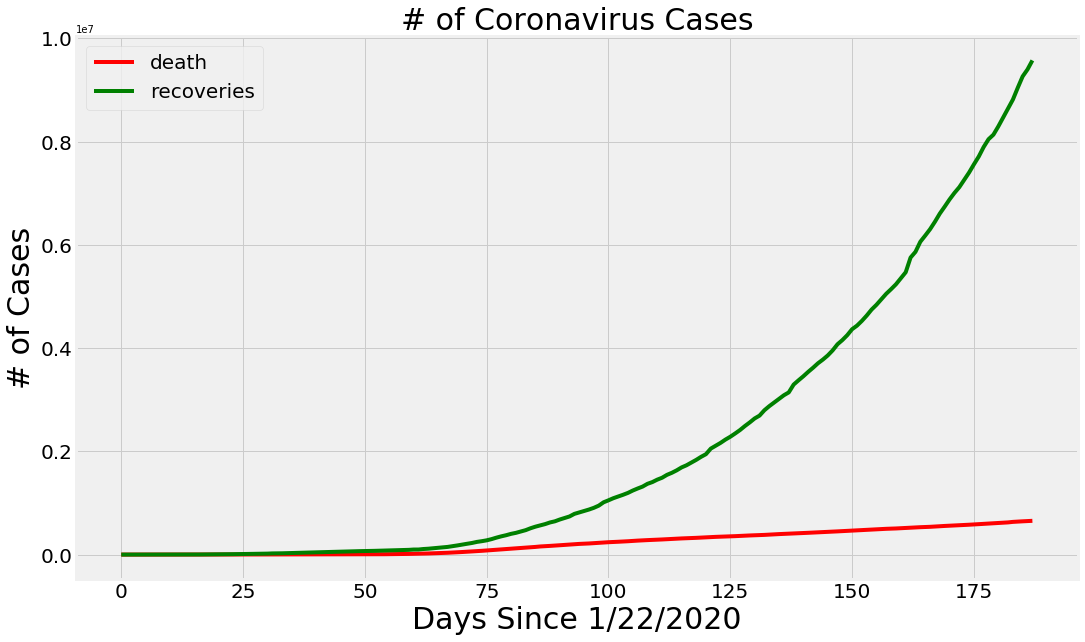

In [61]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Plotting the number of deaths against the number of recoveries

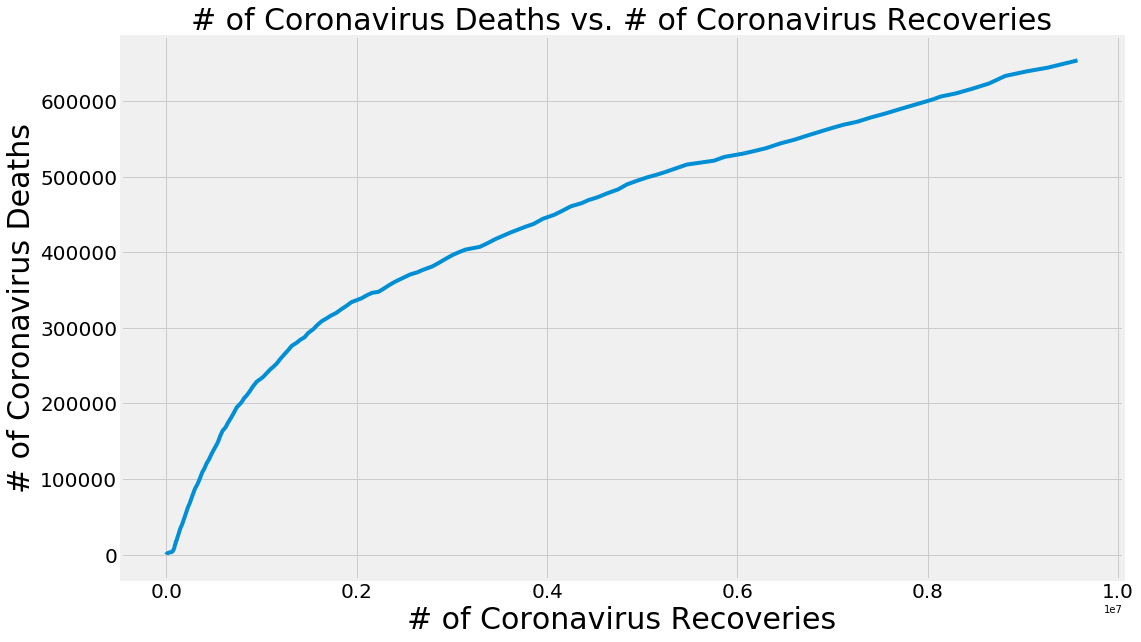

In [64]:
plt.figure(figsize=(16, 10))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Getting information about countries/regions that have confirmed coronavirus cases

In [66]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [69]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

## Data table

In [70]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap='Greens')


In [71]:
unique_provinces =  list(latest_data['Province_State'].unique())

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [73]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_recovery_cases = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [74]:
# number of cases per province/state/city top 100 
province_df = pd.DataFrame({'Province/State Name': unique_provinces[:100], 'Country': province_country[:100], 'Number of Confirmed Cases': province_confirmed_cases[:100],
                          'Number of Deaths': province_death_cases[:100], 'Number of Recoveries' : province_recovery_cases[:100],
                          'Mortality Rate': province_mortality_rate[:100]})
# number of cases per country/region

province_df.style.background_gradient(cmap='Greens')

In [75]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

## Bar Chart Visualizations for COVID-19

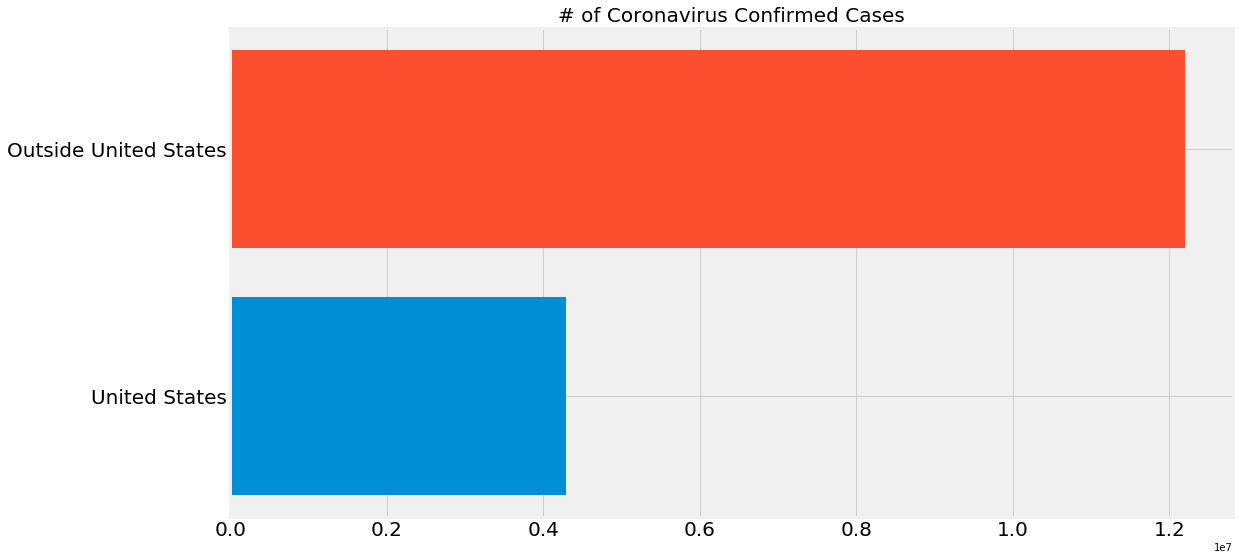

In [76]:
us_confirmed = latest_data[latest_data['Country_Region']=='US']['Confirmed'].sum()
outside_us_confirmed = np.sum(country_confirmed_cases) - us_confirmed
plt.figure(figsize=(16, 9))
plt.barh('United States', us_confirmed)
plt.barh('Outside United States', outside_us_confirmed)
plt.title('# of Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [77]:
print('Outside United States {} cases:'.format(outside_us_confirmed))
print('United States {} cases'.format(us_confirmed))
print('Total: {} cases'.format(us_confirmed+outside_us_confirmed))

Outside United States 12197332 cases:
United States 4290337 cases
Total: 16487669 cases


In [78]:
# Only show 15 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[15:])

for i in range(len(country_confirmed_cases[:15])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

**Visual Representations** (bar charts and pie charts)

In [79]:
def plot_bar_graphs(x, y, title):
    plt.figure(figsize=(16, 12))
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
# good for a lot x values 
def plot_bar_graphs_tall(x, y, title):
    plt.figure(figsize=(19, 18))
    plt.barh(x, y)
    plt.title(title, size=25)
    plt.xticks(size=25)
    plt.yticks(size=25)
    plt.show()

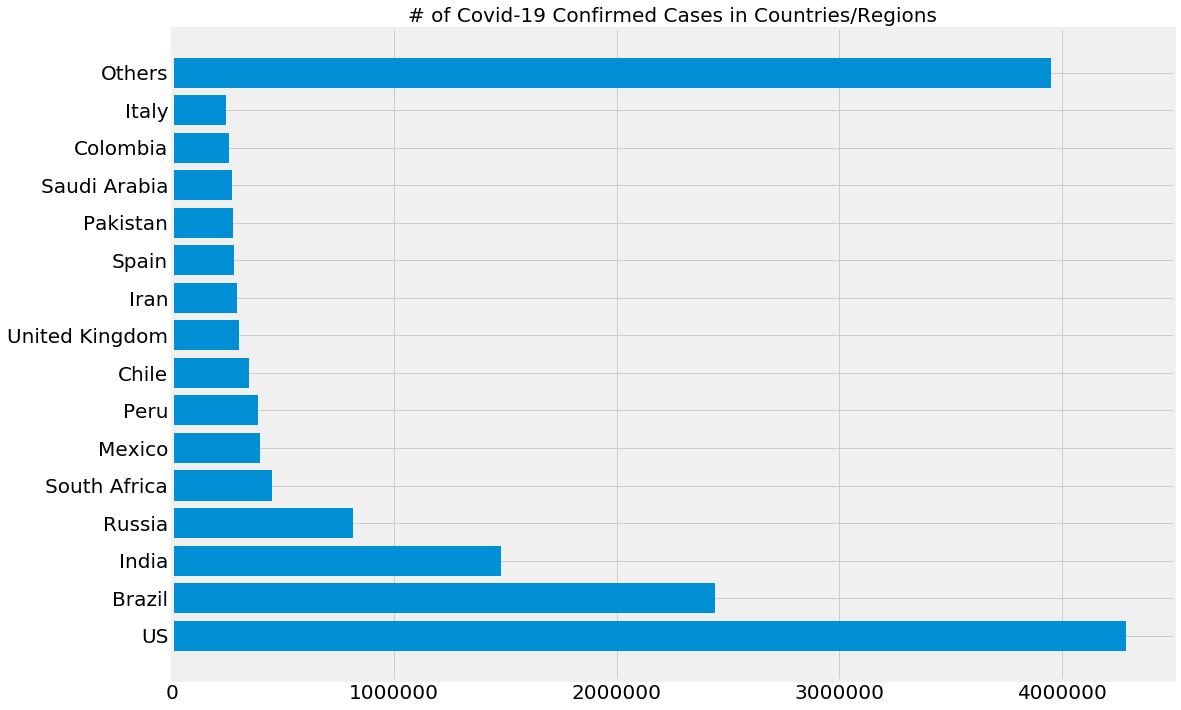

In [80]:
plot_bar_graphs(visual_unique_countries, visual_confirmed_cases, '# of Covid-19 Confirmed Cases in Countries/Regions')

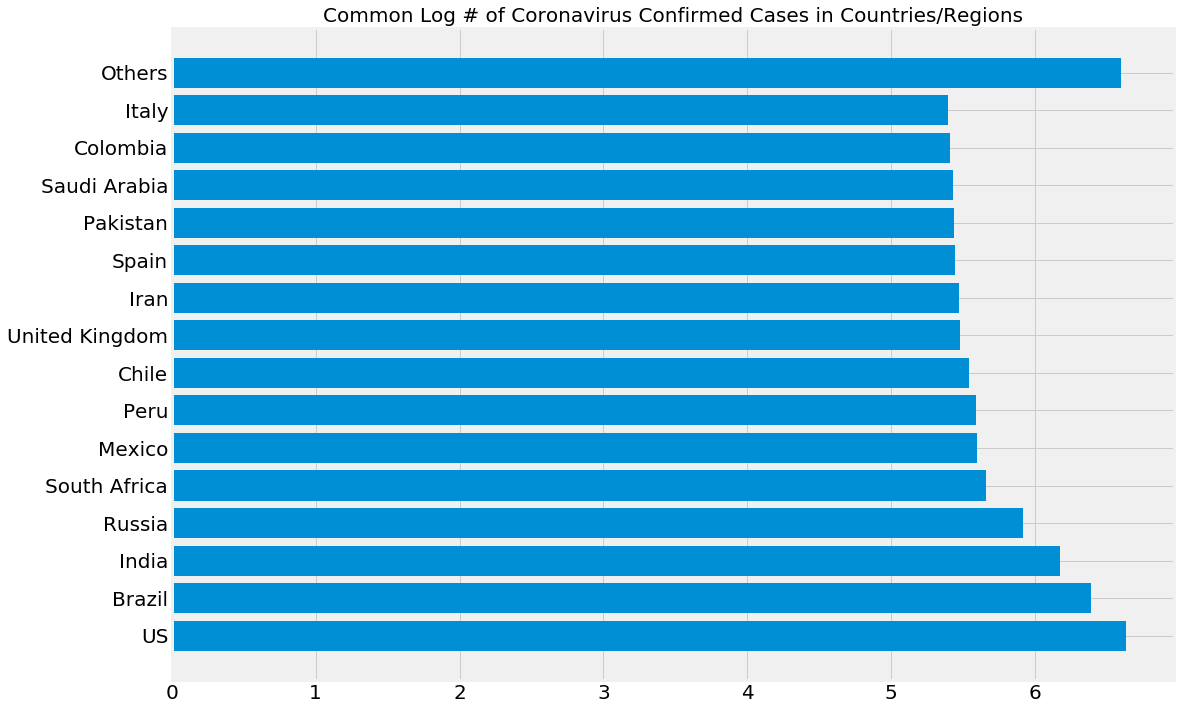

In [81]:
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plot_bar_graphs(visual_unique_countries, log_country_confirmed_cases, 'Common Log # of Coronavirus Confirmed Cases in Countries/Regions')

In [82]:
# Only show 15 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[15:])
for i in range(len(province_confirmed_cases[:15])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

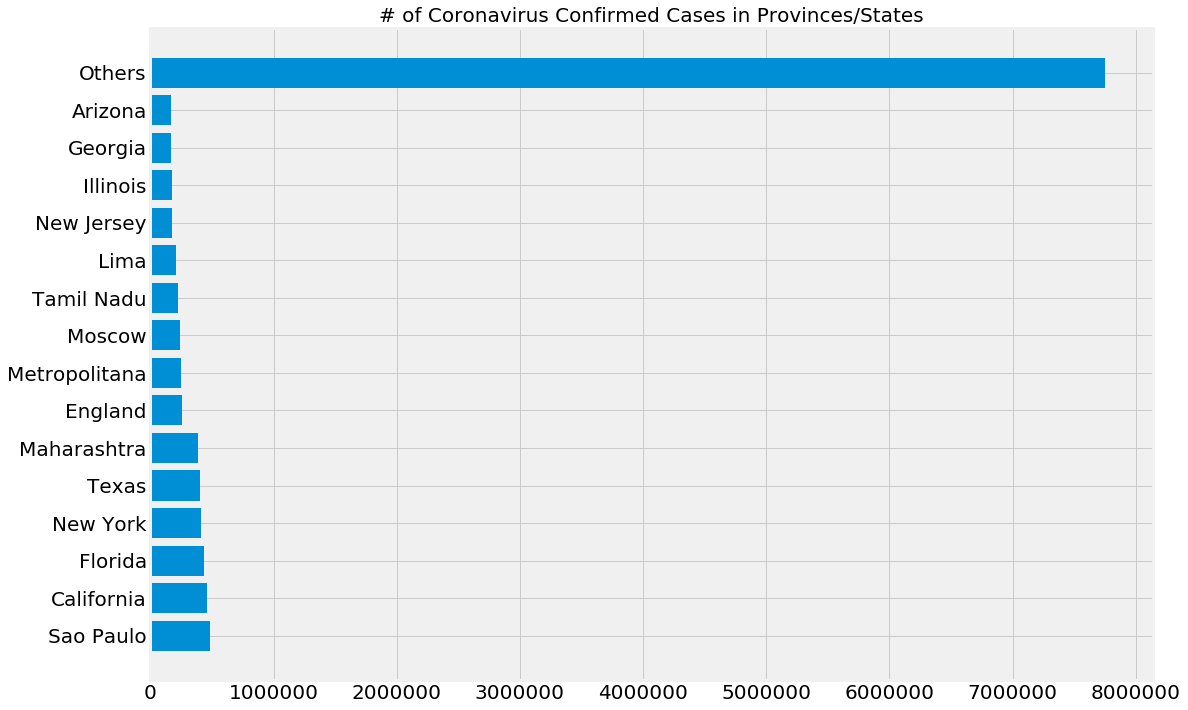

In [83]:
plot_bar_graphs(visual_unique_provinces, visual_confirmed_cases2, '# of Coronavirus Confirmed Cases in Provinces/States')

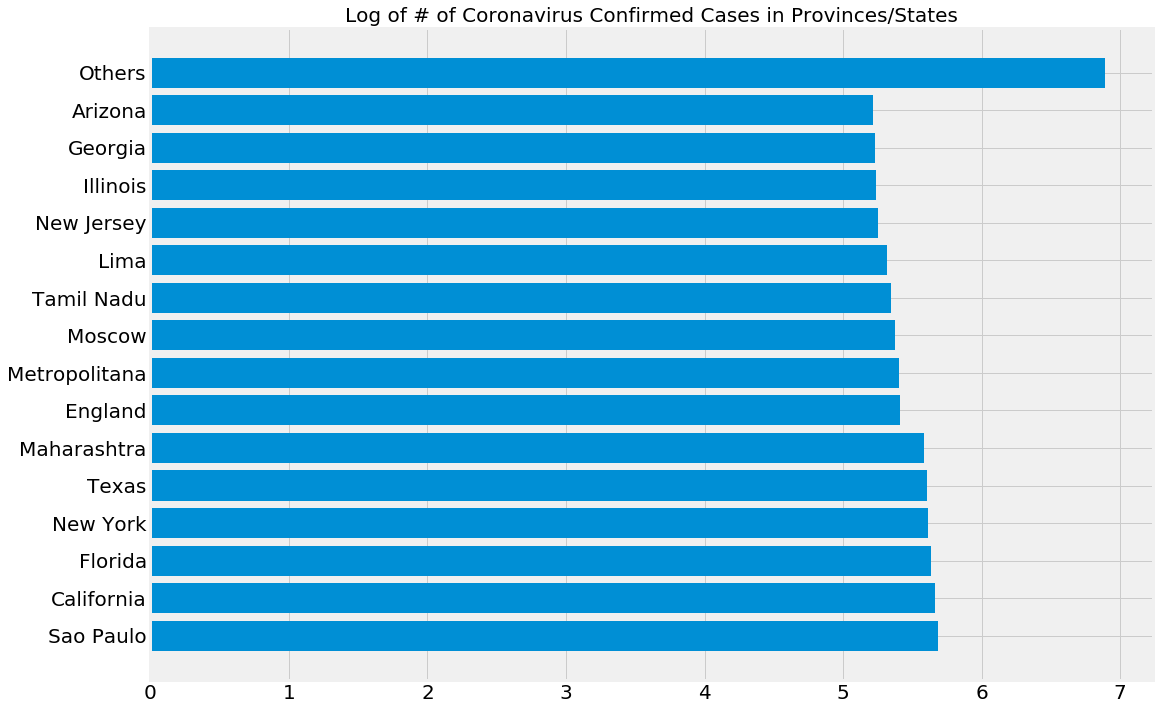

In [91]:
log_province_confirmed_cases = [math.log10(i) 
                                for i in visual_confirmed_cases2]
plot_bar_graphs(visual_unique_provinces,
                log_province_confirmed_cases, 
                'Log of # of Coronavirus Confirmed Cases in Provinces/States')

## Pie Chart Visualizations for COVID-19

In [86]:
def plot_pie_charts(x, y, title):
    c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, colors=c)
    plt.legend(x, loc='best', fontsize=15)
    plt.show()

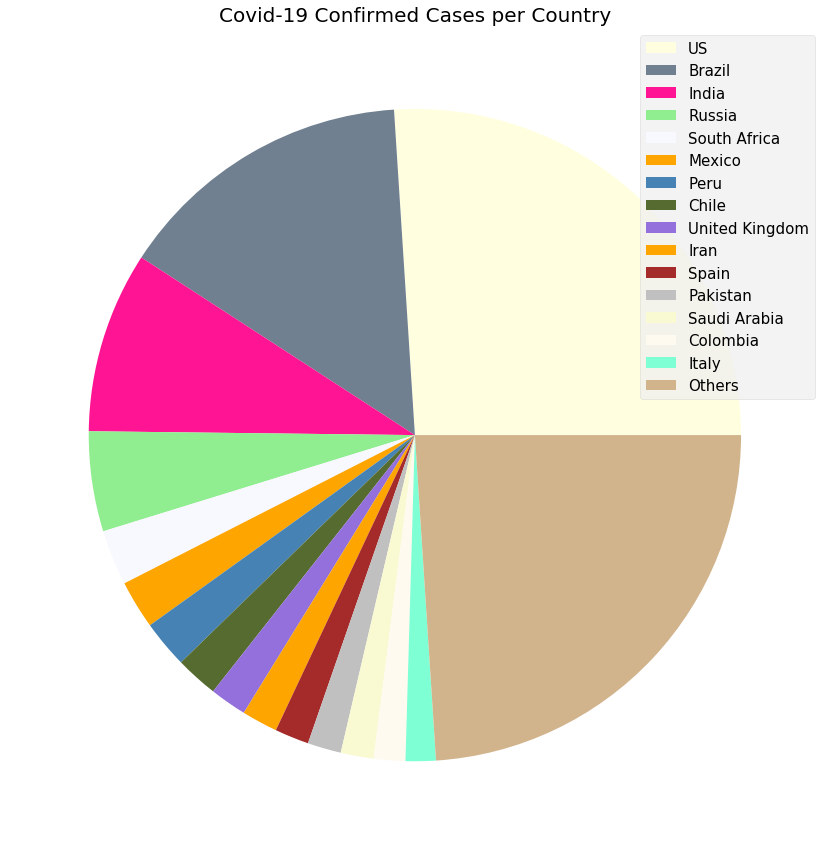

In [89]:
plot_pie_charts(visual_unique_countries, 
                visual_confirmed_cases, 
                'Covid-19 Confirmed Cases per Country')

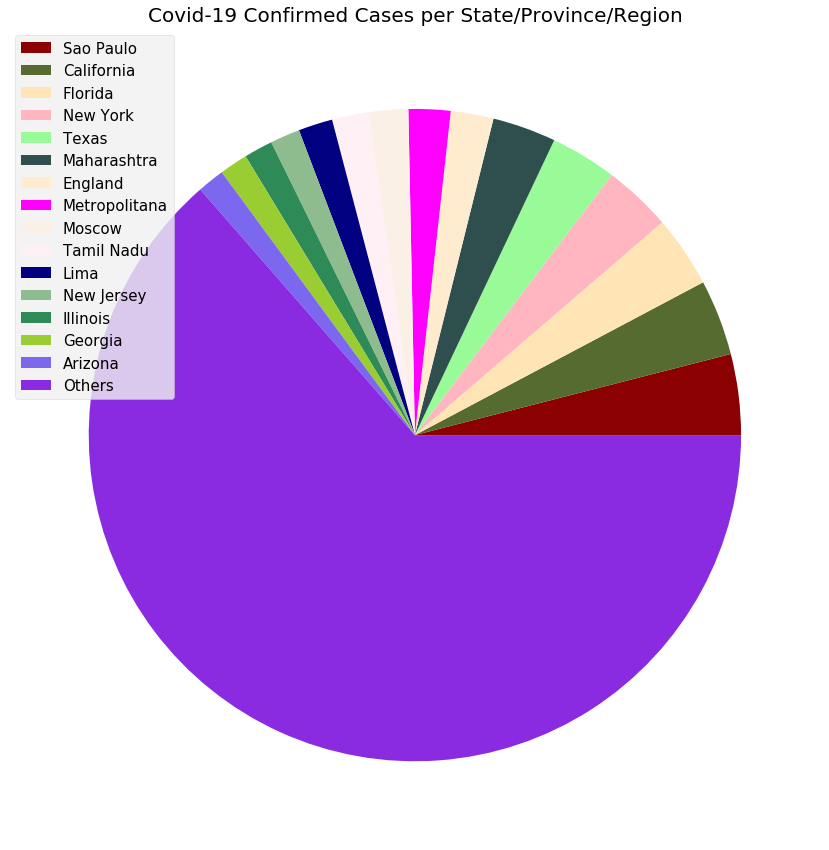

In [90]:
plot_pie_charts(visual_unique_provinces,
                visual_confirmed_cases2,
                'Covid-19 Confirmed Cases per State/Province/Region')

In [94]:
# Plotting countries with regional data using a pie chart 


def plot_pie_country_with_regions(country_name, title):
    regions = list(latest_data[latest_data['Country_Region']==country_name]['Province_State'].unique())
    confirmed_cases = []
    no_cases = [] 
    for i in regions:
        cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
        if cases > 0:
            confirmed_cases.append(cases)
        else:
            no_cases.append(i)

    # remove areas with no confirmed cases
    for i in no_cases:
        regions.remove(i)

    # only show the top 5 states
    regions = [k for k, v in sorted(zip(regions, confirmed_cases), 
                                    key=operator.itemgetter(1), reverse=True)]

    for i in range(len(regions)):
        confirmed_cases[i] = latest_data[latest_data['Province_State']==regions[i]]['Confirmed'].sum()  
    
    # additional province/state will be considered "others"
    
    if(len(regions)>5):
        regions_5 = regions[:5]
        regions_5.append('Others')
        confirmed_cases_5 = confirmed_cases[:5]
        confirmed_cases_5.append(np.sum(confirmed_cases[5:]))
        plot_pie_charts(regions_5,confirmed_cases_5, title)
    else:
        plot_pie_charts(regions,confirmed_cases, title)

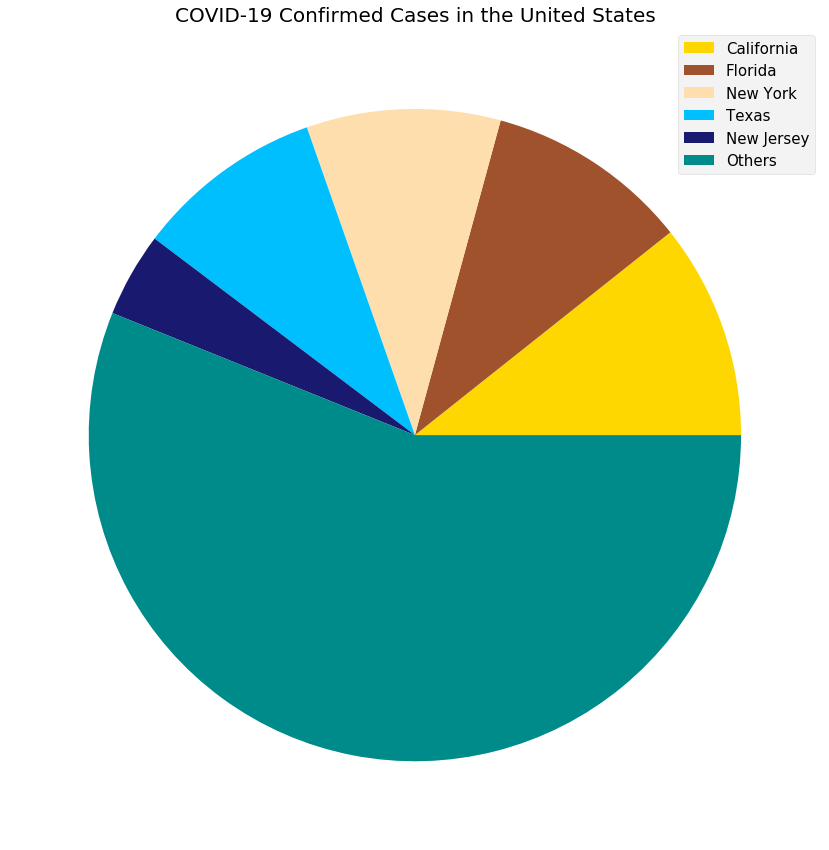

In [95]:
plot_pie_country_with_regions('US', 'COVID-19 Confirmed Cases in the United States')

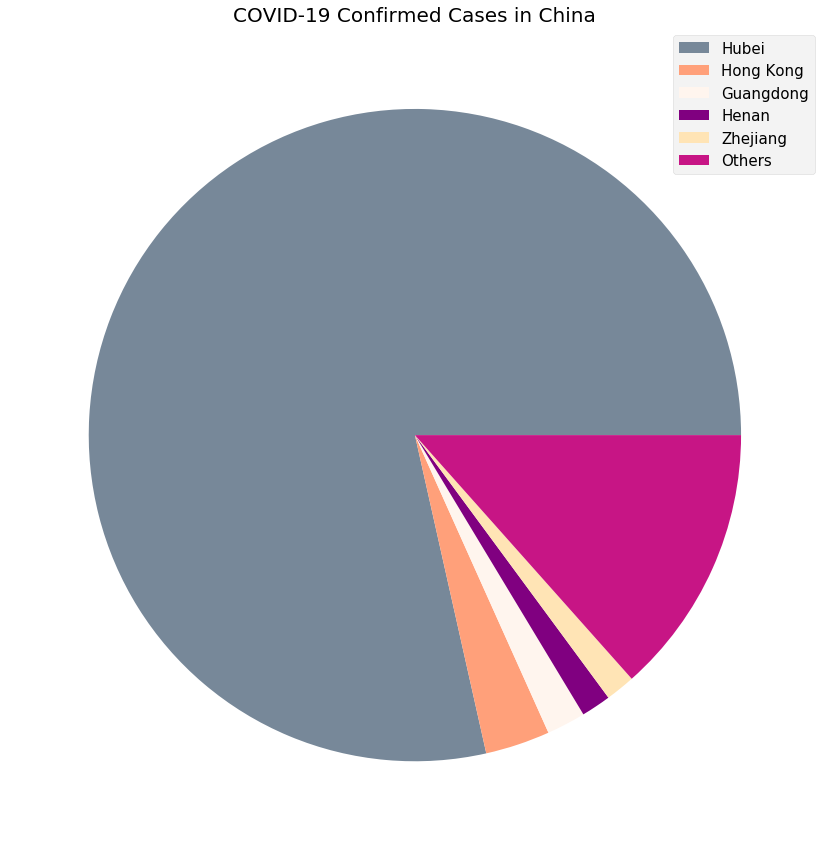

In [96]:
plot_pie_country_with_regions('China', 'COVID-19 Confirmed Cases in China')

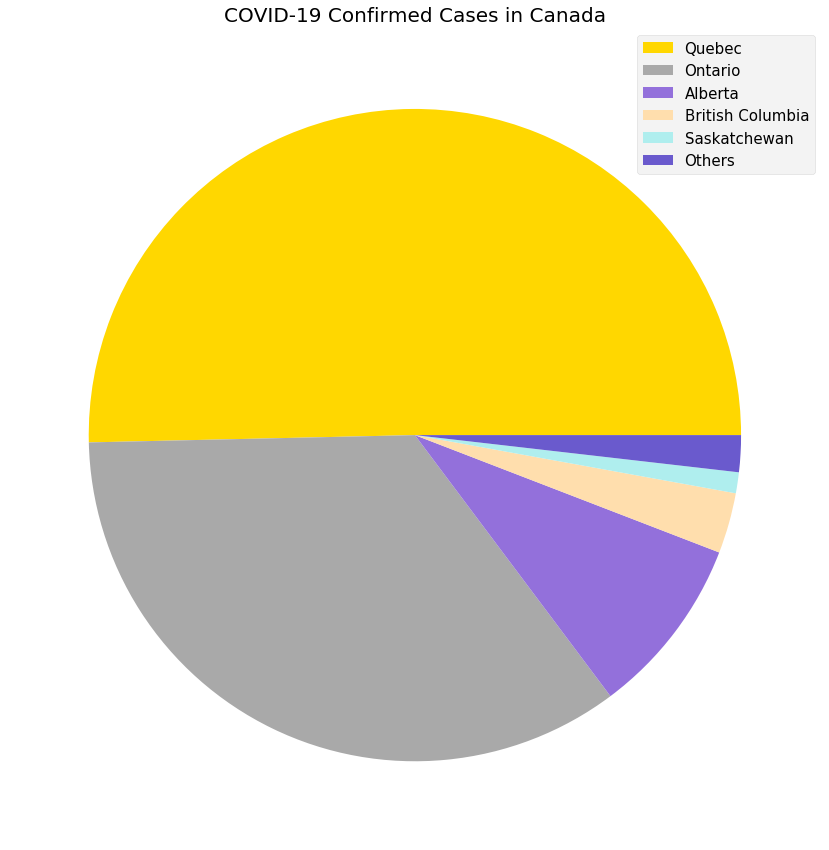

In [97]:
plot_pie_country_with_regions('Canada', 'COVID-19 Confirmed Cases in Canada')

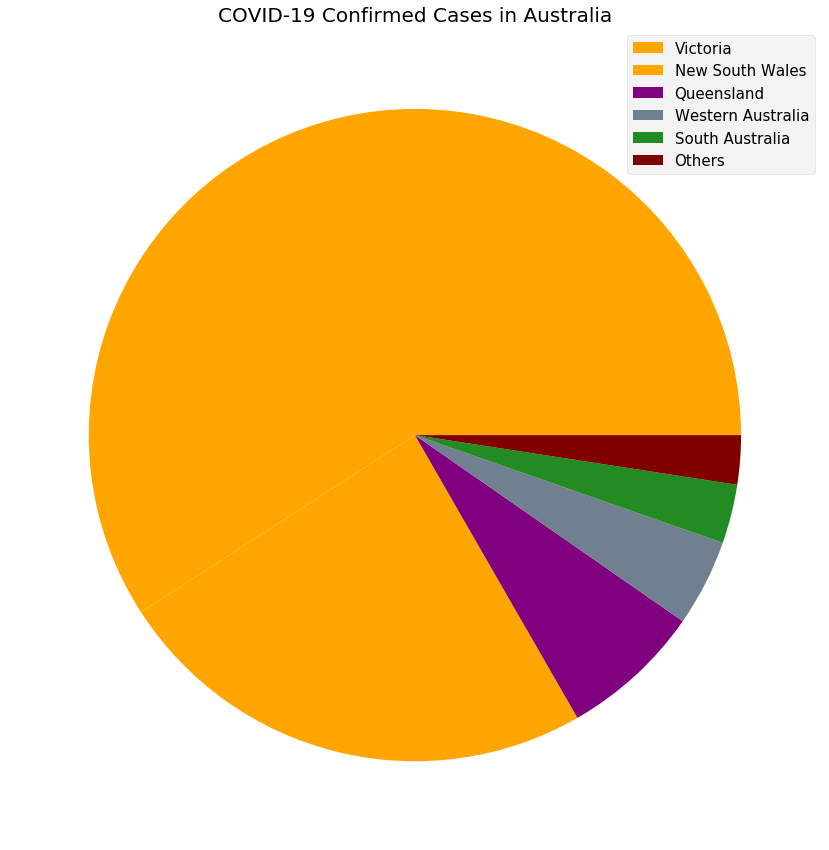

In [98]:
plot_pie_country_with_regions('Australia', 'COVID-19 Confirmed Cases in Australia')

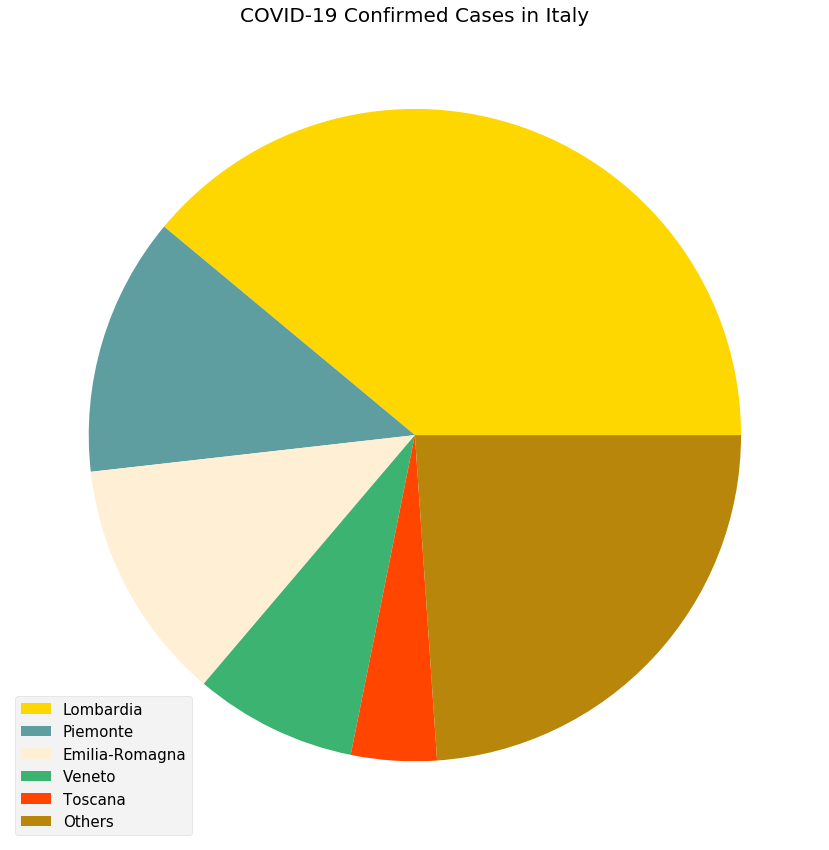

In [102]:
plot_pie_country_with_regions('Italy', 'COVID-19 Confirmed Cases in Italy')

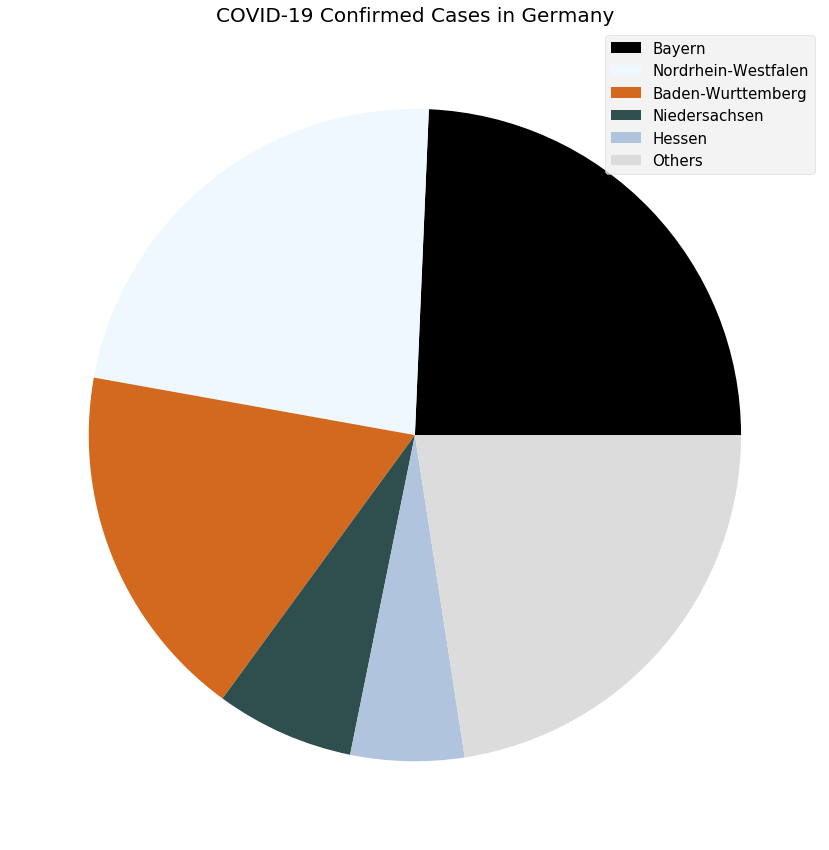

In [103]:
plot_pie_country_with_regions('Germany', 'COVID-19 Confirmed Cases in Germany')

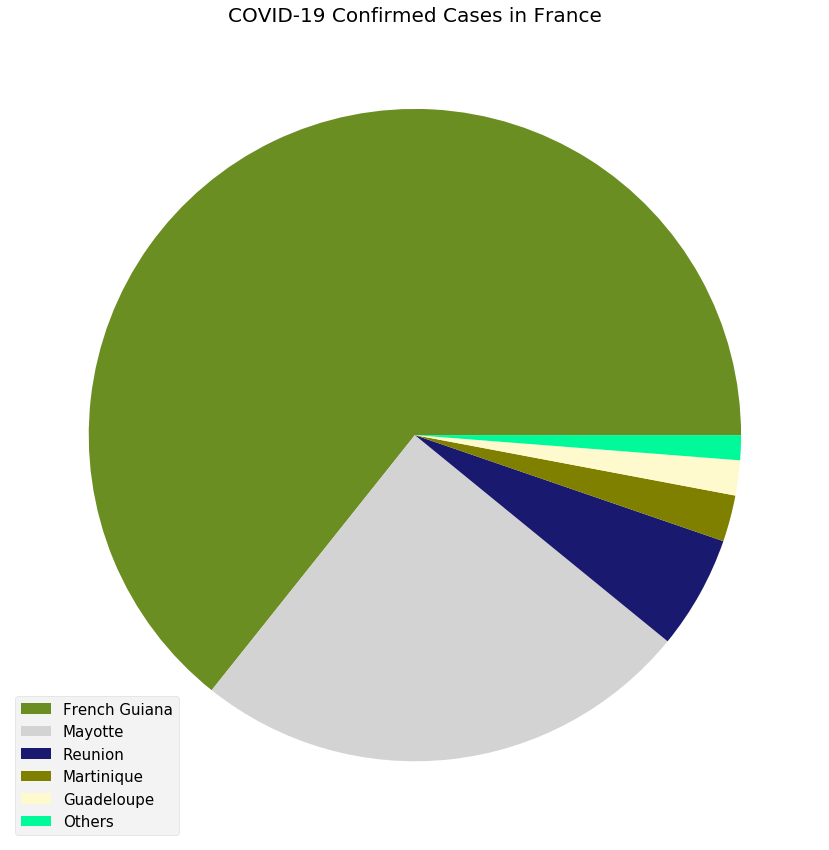

In [104]:
plot_pie_country_with_regions('France', 'COVID-19 Confirmed Cases in France')

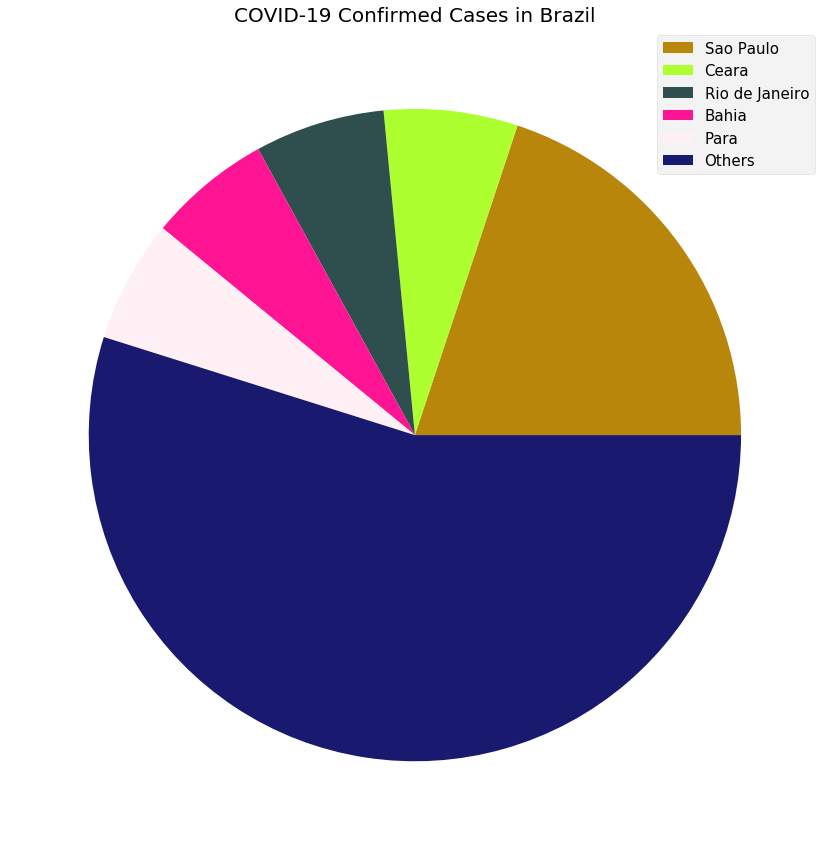

In [105]:
plot_pie_country_with_regions('Brazil', 'COVID-19 Confirmed Cases in Brazil')

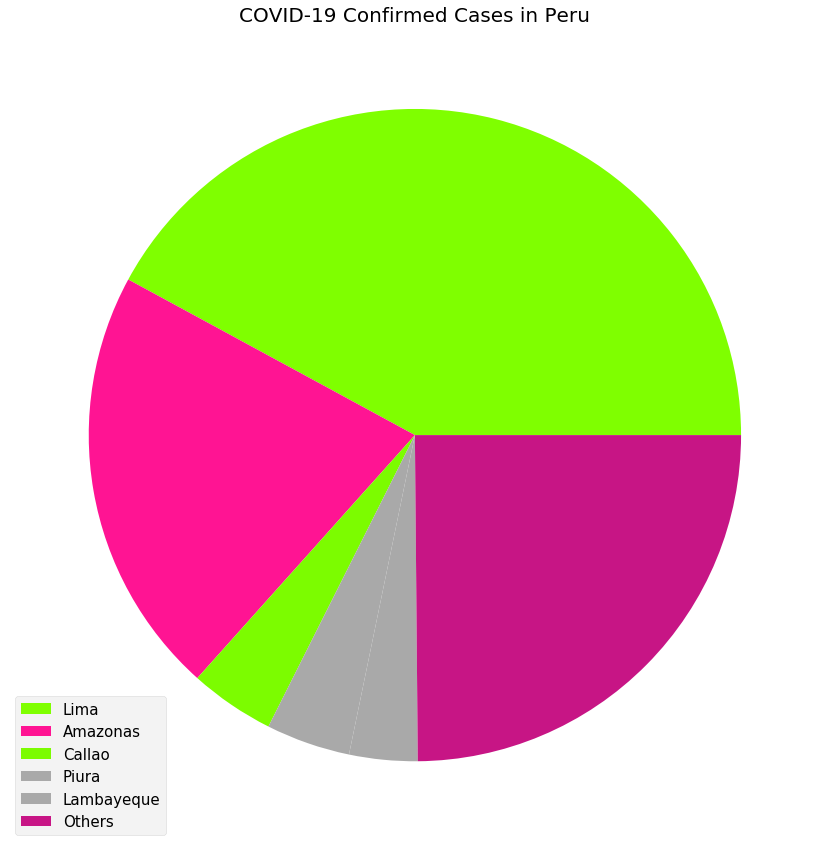

In [106]:
plot_pie_country_with_regions('Peru', 'COVID-19 Confirmed Cases in Peru')

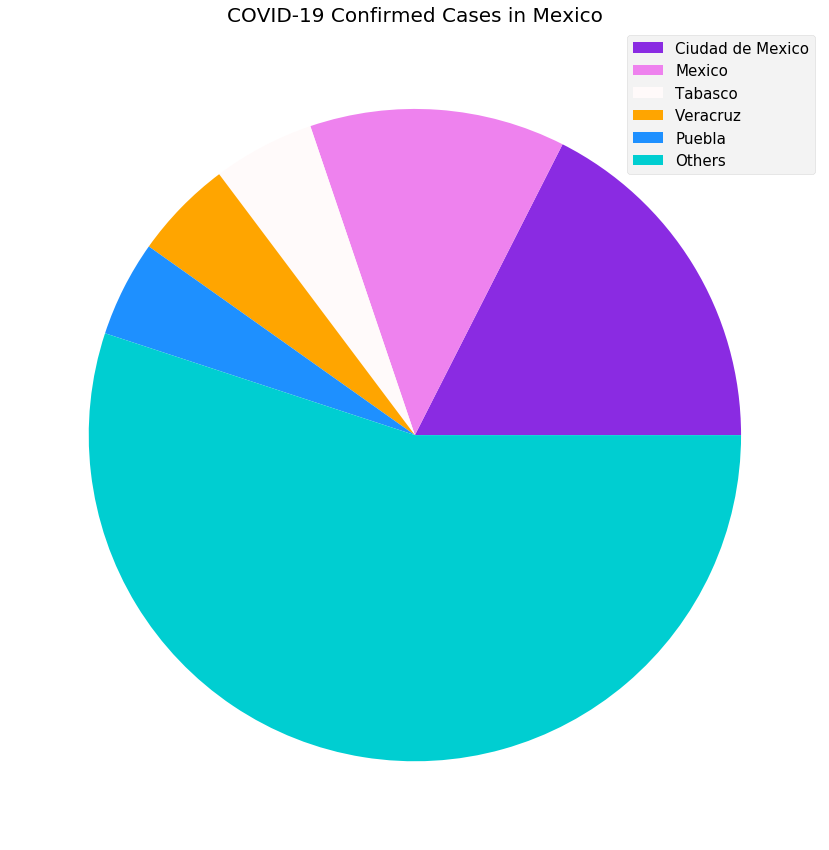

In [107]:
plot_pie_country_with_regions('Mexico', 'COVID-19 Confirmed Cases in Mexico')